# 2. MCF7 Data Preprocessing and Filtering



Now, similarely to the previous dataset, we proceed to the analysis of MCF7 Dataset, in the same flavour of the notebook 1. We will, indeed, analyze this second unfiltered data applying techniques and methods already explained in the first analysis.

In [1]:
# Importing the libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 
sns.set(color_codes=True)
import torch as th
from sklearn.preprocessing import StandardScaler
from scipy.stats import skew, kurtosis, kstest, poisson, chisquare, nbinom, gamma, chi2_contingency, mannwhitneyu
import scipy.stats as stats
import random
import scanpy as sc
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from collections import defaultdict
from sklearn.metrics.pairwise import euclidean_distances
import plotly

# EDA (Exploratory Data Analysis)


## Metadata files 

In [2]:
df_metaM_path = '../ai_lab/SmartSeq/MCF7_SmartS_MetaData.tsv'
df_metaM = pd.read_csv(df_metaM_path, delimiter='\t')
print("Dataframe dimensions:", df_metaM.shape)
print("Dataframe columns:", df_metaM.columns)

Dataframe dimensions: (383, 9)
Dataframe columns: Index(['Filename', 'Cell Line', 'Lane', 'Pos', 'Condition', 'Hours',
       'Cell name', 'PreprocessingTag', 'ProcessingComments'],
      dtype='object')


In [3]:
df_metaM.head()

Filename Cell Line           Lane  \
0  output.STAR.1_A10_Hypo_S28_Aligned.sortedByCoo...      MCF7  output.STAR.1   
1  output.STAR.1_A11_Hypo_S29_Aligned.sortedByCoo...      MCF7  output.STAR.1   
2  output.STAR.1_A12_Hypo_S30_Aligned.sortedByCoo...      MCF7  output.STAR.1   
3  output.STAR.1_A1_Norm_S1_Aligned.sortedByCoord...      MCF7  output.STAR.1   
4  output.STAR.1_A2_Norm_S2_Aligned.sortedByCoord...      MCF7  output.STAR.1   

   Pos Condition  Hours Cell name               PreprocessingTag  \
0  A10      Hypo     72       S28  Aligned.sortedByCoord.out.bam   
1  A11      Hypo     72       S29  Aligned.sortedByCoord.out.bam   
2  A12      Hypo     72       S30  Aligned.sortedByCoord.out.bam   
3   A1      Norm     72        S1  Aligned.sortedByCoord.out.bam   
4   A2      Norm     72        S2  Aligned.sortedByCoord.out.bam   

   ProcessingComments  
0  STAR,FeatureCounts  
1  STAR,FeatureCounts  
2  STAR,FeatureCounts  
3  STAR,FeatureCounts  
4  STAR,FeatureCounts

Condition
Norm    192
Hypo    191
Name: count, dtype: int64


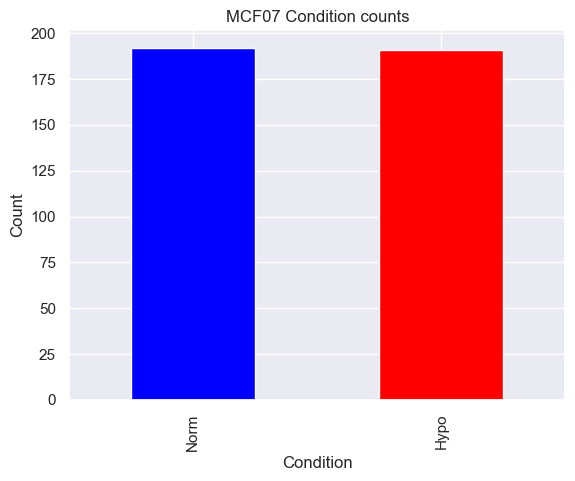

In [4]:
# before starting the analysis of seqdata we check the counts for Norm or Hypo as we did for the other dataset
# in the column 'Condition' for both the datasets count the number of Norm and Hypo
counts = df_metaM['Condition'].value_counts()
# Histogram of the counts
print(counts)
# Plot the histogram with two columns for each condition
counts.plot(kind='bar', color=['blue', 'red'])
plt.title('MCF07 Condition counts')
plt.xlabel('Condition')
plt.ylabel('Count')
plt.show()

Again, the dataset is balanced since the counts are almost the same.

## Sequencing Data 

In [5]:
#We just create the path and the dataset on Python
df_seq_pathHFilt = '../ai_lab/SmartSeq/HCC1806_SmartS_Filtered_Data.txt'

df_seq_pathHFiltNorm = '../ai_lab/SmartSeq/HCC1806_SmartS_Filtered_Normalised_3000_Data_train.txt'

df_seq_pathHUnfilt = '../ai_lab/SmartSeq/HCC1806_SmartS_Unfiltered_Data.txt'

df_seq_pathMFilt = '../ai_lab/SmartSeq/MCF7_SmartS_Filtered_Data.txt'

df_seq_pathMFiltNorm = '../ai_lab/SmartSeq/MCF7_SmartS_Filtered_Normalised_3000_Data_train.txt'

df_seq_pathMUnfilt = '../ai_lab/SmartSeq/MCF7_SmartS_Unfiltered_Data.txt'

df_seq_HFilt = pd.read_csv(df_seq_pathHFilt, delimiter=' ')

df_seq_HFiltNorm = pd.read_csv(df_seq_pathHFiltNorm, delimiter=' ')

df_seq_HUnfilt = pd.read_csv(df_seq_pathHUnfilt, delimiter=' ')

df_seq_MFilt = pd.read_csv(df_seq_pathMFilt, delimiter=' ')

df_seq_MFiltNorm = pd.read_csv(df_seq_pathMFiltNorm, delimiter=' ')

df_seq_MUnfilt = pd.read_csv(df_seq_pathMUnfilt, delimiter=' ')

## Description

In [6]:
# Focus now on MCF7 Unfiltered
print("Dataframe dimension:", df_seq_MUnfilt.shape)
print("First Column:", df_seq_MUnfilt.iloc[:,0])
print("Columns list:", list(df_seq_MUnfilt.columns))

Dataframe dimension: (22934, 383)
First Column: WASH7P         0
MIR6859-1      0
WASH9P         1
OR4F29         0
MTND1P23       0
            ... 
MT-TE          4
MT-CYB       270
MT-TT          0
MT-TP          5
MAFIP          8
Name: output.STAR.1_A10_Hypo_S28_Aligned.sortedByCoord.out.bam, Length: 22934, dtype: int64
Columns list: ['output.STAR.1_A10_Hypo_S28_Aligned.sortedByCoord.out.bam', 'output.STAR.1_A11_Hypo_S29_Aligned.sortedByCoord.out.bam', 'output.STAR.1_A12_Hypo_S30_Aligned.sortedByCoord.out.bam', 'output.STAR.1_A1_Norm_S1_Aligned.sortedByCoord.out.bam', 'output.STAR.1_A2_Norm_S2_Aligned.sortedByCoord.out.bam', 'output.STAR.1_A3_Norm_S3_Aligned.sortedByCoord.out.bam', 'output.STAR.1_A4_Norm_S4_Aligned.sortedByCoord.out.bam', 'output.STAR.1_A5_Norm_S5_Aligned.sortedByCoord.out.bam', 'output.STAR.1_A6_Norm_S6_Aligned.sortedByCoord.out.bam', 'output.STAR.1_A7_Hypo_S25_Aligned.sortedByCoord.out.bam', 'output.STAR.1_A8_Hypo_S26_Aligned.sortedByCoord.out.bam', 'output.STAR

In [7]:
# Check for the types of data in the dataframe
print("Data types in the dataframe:", df_seq_MUnfilt.dtypes.unique())
# Check for features
gene_symbols = df_seq_MUnfilt.index
print("Gene symbols in the dataframe:",gene_symbols)

Data types in the dataframe: [dtype('int64')]
Gene symbols in the dataframe: Index(['WASH7P', 'MIR6859-1', 'WASH9P', 'OR4F29', 'MTND1P23', 'MTND2P28',
       'MTCO1P12', 'MTCO2P12', 'MTATP8P1', 'MTATP6P1',
       ...
       'MT-TH', 'MT-TS2', 'MT-TL2', 'MT-ND5', 'MT-ND6', 'MT-TE', 'MT-CYB',
       'MT-TT', 'MT-TP', 'MAFIP'],
      dtype='object', length=22934)


In [8]:
# Take the transpose of the dataframe
print("Dataframe dimension before transpose:", df_seq_MUnfilt.shape)
df_seq_MUnfilt = df_seq_MUnfilt.T
print("Dataframe dimension after transpose:", df_seq_MUnfilt.shape)
df_seq_MUnfilt.head(5)

Dataframe dimension before transpose: (22934, 383)
Dataframe dimension after transpose: (383, 22934)


WASH7P  MIR6859-1  WASH9P  \
output.STAR.1_A10_Hypo_S28_Aligned.sortedByCoor...       0          0       1   
output.STAR.1_A11_Hypo_S29_Aligned.sortedByCoor...       0          0       0   
output.STAR.1_A12_Hypo_S30_Aligned.sortedByCoor...       0          0       0   
output.STAR.1_A1_Norm_S1_Aligned.sortedByCoord....       0          0       0   
output.STAR.1_A2_Norm_S2_Aligned.sortedByCoord....       0          0       0   

                                                    OR4F29  MTND1P23  \
output.STAR.1_A10_Hypo_S28_Aligned.sortedByCoor...       0         0   
output.STAR.1_A11_Hypo_S29_Aligned.sortedByCoor...       0         0   
output.STAR.1_A12_Hypo_S30_Aligned.sortedByCoor...       0         0   
output.STAR.1_A1_Norm_S1_Aligned.sortedByCoord....       0         0   
output.STAR.1_A2_Norm_S2_Aligned.sortedByCoord....       0         0   

                                                    MTND2P28  MTCO1P12  \
output.STAR.1_A10_Hypo_S28_Aligned.sortedByCoor...         2         2   
output.STAR.1_A11_Hypo_S29_Aligned.sortedByCoor...         0         0   
output.STAR.1_A12_Hypo_S30_Aligned.sortedByCoor...         1         1   
output.STAR.1_A1_Norm_S1_Aligned.sortedByCoord....         0         0   
output.STAR.1_A2_Norm_S2_Aligned.sortedByCoord....         0         0   

                                                    MTCO2P12  MTATP8P1  \
output.STAR.1_A10_Hypo_S28_Aligned.sortedByCoor...         0         0   
output.STAR.1_A11_Hypo_S29_Aligned.sortedByCoor...         0         0   
output.STAR.1_A12_Hypo_S30_Aligned.sortedByCoor...         1         0   
output.STAR.1_A1_Norm_S1_Aligned.sortedByCoord....         0         0   
output.STAR.1_A2_Norm_S2_Aligned.sortedByCoord....         0         0   

                                                    MTATP6P1  ...  MT-TH  \
output.STAR.1_A10_Hypo_S28_Aligned.sortedByCoor...        29  ...      0   
output.STAR.1_A11_Hypo_S29_Aligned.sortedByCoor...         0  ...      1   
output.STAR.1_A12_Hypo_S30_Aligned.sortedByCoor...        12  ...      0   
output.STAR.1_A1_Norm_S1_Aligned.sortedByCoord....         7  ...      1   
output.STAR.1_A2_Norm_S2_Aligned.sortedByCoord....        68  ...      0   

                                                    MT-TS2  MT-TL2  MT-ND5  \
output.STAR.1_A10_Hypo_S28_Aligned.sortedByCoor...       0       0     505   
output.STAR.1_A11_Hypo_S29_Aligned.sortedByCoor...       1       0       1   
output.STAR.1_A12_Hypo_S30_Aligned.sortedByCoor...       0       0       1   
output.STAR.1_A1_Norm_S1_Aligned.sortedByCoord....       0       0      44   
output.STAR.1_A2_Norm_S2_Aligned.sortedByCoord....       0       0     237   

                                                    MT-ND6  MT-TE  MT-CYB  \
output.STAR.1_A10_Hypo_S28_Aligned.sortedByCoor...     147      4     270   
output.STAR.1_A11_Hypo_S29_Aligned.sortedByCoor...       0      0       1   
output.STAR.1_A12_Hypo_S30_Aligned.sortedByCoor...       0      0      76   
output.STAR.1_A1_Norm_S1_Aligned.sortedByCoord....       8      0      66   
output.STAR.1_A2_Norm_S2_Aligned.sortedByCoord....      31      3     727   

                                                    MT-TT  MT-TP  MAFIP  
output.STAR.1_A10_Hypo_S28_Aligned.sortedByCoor...      0      5      8  
output.STAR.1_A11_Hypo_S29_Aligned.sortedByCoor...      0      0      0  
output.STAR.1_A12_Hypo_S30_Aligned.sortedByCoor...      0      0      0  
output.STAR.1_A1_Norm_S1_Aligned.sortedByCoord....      0      1      0  
output.STAR.1_A2_Norm_S2_Aligned.sortedByCoord....      0      0      0  

[5 rows x 22934 columns]

In [9]:
# Which gene is expressed the least
min_expressed_gene = df_seq_MUnfilt.sum(axis=0).idxmin()
print("Gene with the least expression:", min_expressed_gene)
print("Number of samples:", df_seq_MUnfilt.sum(axis=0).min())
# Which gene is expressed the most
max_expressed_gene = df_seq_MUnfilt.sum(axis=0).idxmax()
print("Gene with the most expression:", max_expressed_gene)
print("Number of samples:", df_seq_MUnfilt.sum(axis=0).max())

Gene with the least expression: CICP3
Number of samples: 2
Gene with the most expression: KRT8
Number of samples: 8829208


In [10]:
# Now we look at evetual missing values in the dataframe
print("Missing values in the dataframe by columns:", df_seq_MUnfilt.isnull().sum())
print("Missing values in the whole dataframe:", df_seq_MUnfilt.isna().sum().sum())

Missing values in the dataframe by columns: WASH7P       0
MIR6859-1    0
WASH9P       0
OR4F29       0
MTND1P23     0
            ..
MT-TE        0
MT-CYB       0
MT-TT        0
MT-TP        0
MAFIP        0
Length: 22934, dtype: int64
Missing values in the whole dataframe: 0


In [11]:
# Summary statistics of the dataframe
df_seq_MUnfilt.describe()

WASH7P   MIR6859-1      WASH9P     OR4F29    MTND1P23    MTND2P28  \
count  383.000000  383.000000  383.000000  383.00000  383.000000  383.000000   
mean     0.133159    0.026110    1.344648    0.05483    0.049608    6.261097   
std      0.618664    0.249286    2.244543    0.31477    0.229143    7.565749   
min      0.000000    0.000000    0.000000    0.00000    0.000000    0.000000   
25%      0.000000    0.000000    0.000000    0.00000    0.000000    0.000000   
50%      0.000000    0.000000    0.000000    0.00000    0.000000    3.000000   
75%      0.000000    0.000000    2.000000    0.00000    0.000000   10.000000   
max      9.000000    4.000000   20.000000    3.00000    2.000000   45.000000   

         MTCO1P12    MTCO2P12    MTATP8P1     MTATP6P1  ...       MT-TH  \
count  383.000000  383.000000  383.000000   383.000000  ...  383.000000   
mean     4.681462    0.524804    0.073107   222.054830  ...    1.060052   
std      6.232649    0.980857    0.298131   262.616874  ...    1.990566   
min      0.000000    0.000000    0.000000     0.000000  ...    0.000000   
25%      0.000000    0.000000    0.000000    23.000000  ...    0.000000   
50%      2.000000    0.000000    0.000000    98.000000  ...    0.000000   
75%      7.000000    1.000000    0.000000   370.500000  ...    1.000000   
max     36.000000    6.000000    2.000000  1662.000000  ...   15.000000   

           MT-TS2      MT-TL2       MT-ND5       MT-ND6       MT-TE  \
count  383.000000  383.000000   383.000000   383.000000  383.000000   
mean     0.443864    3.146214  1016.477807   204.600522    5.049608   
std      1.090827    4.265352  1009.444811   220.781927    6.644302   
min      0.000000    0.000000     0.000000     0.000000    0.000000   
25%      0.000000    0.000000   172.000000    30.500000    0.000000   
50%      0.000000    1.000000   837.000000   152.000000    3.000000   
75%      0.000000    5.000000  1549.000000   294.000000    7.000000   
max      8.000000   22.000000  8115.000000  2002.000000   46.000000   

            MT-CYB       MT-TT       MT-TP       MAFIP  
count    383.00000  383.000000  383.000000  383.000000  
mean    2374.97389    2.083551    5.626632    1.749347  
std     2920.39000    3.372714    7.511180    3.895204  
min        0.00000    0.000000    0.000000    0.000000  
25%      216.50000    0.000000    0.000000    0.000000  
50%      785.00000    0.000000    3.000000    0.000000  
75%     4059.00000    3.000000    8.000000    2.000000  
max    16026.00000   22.000000   56.000000   32.000000  

[8 rows x 22934 columns]

In [12]:
def add_target_column(data, metadata_path, target_column_name, target_category):
    df_meta = pd.read_csv(metadata_path, delimiter='\t')
    df_meta.set_index('Filename', inplace=True)
    merged_transition = pd.merge(data, df_meta[target_column_name], left_index=True, right_index=True)
    dummy_variables = pd.get_dummies(merged_transition[target_column_name], prefix='category').astype('int')
    
    # Set the target category to 1 and the others to 0
    dummy_variables['Target'] = dummy_variables[target_category]
    dummy_variables.drop(columns=[col for col in dummy_variables.columns if col != 'Target'], inplace=True)
    
    merged_data = pd.concat([merged_transition, dummy_variables], axis=1)
    merged_data.drop(columns=[target_column_name], inplace=True)
    return merged_data

In [13]:
merged = add_target_column(df_seq_MUnfilt, df_metaM_path, 'Condition', 'category_Norm')

In [14]:
merged.head()

WASH7P  MIR6859-1  WASH9P  \
output.STAR.1_A10_Hypo_S28_Aligned.sortedByCoor...       0          0       1   
output.STAR.1_A11_Hypo_S29_Aligned.sortedByCoor...       0          0       0   
output.STAR.1_A12_Hypo_S30_Aligned.sortedByCoor...       0          0       0   
output.STAR.1_A1_Norm_S1_Aligned.sortedByCoord....       0          0       0   
output.STAR.1_A2_Norm_S2_Aligned.sortedByCoord....       0          0       0   

                                                    OR4F29  MTND1P23  \
output.STAR.1_A10_Hypo_S28_Aligned.sortedByCoor...       0         0   
output.STAR.1_A11_Hypo_S29_Aligned.sortedByCoor...       0         0   
output.STAR.1_A12_Hypo_S30_Aligned.sortedByCoor...       0         0   
output.STAR.1_A1_Norm_S1_Aligned.sortedByCoord....       0         0   
output.STAR.1_A2_Norm_S2_Aligned.sortedByCoord....       0         0   

                                                    MTND2P28  MTCO1P12  \
output.STAR.1_A10_Hypo_S28_Aligned.sortedByCoor...         2         2   
output.STAR.1_A11_Hypo_S29_Aligned.sortedByCoor...         0         0   
output.STAR.1_A12_Hypo_S30_Aligned.sortedByCoor...         1         1   
output.STAR.1_A1_Norm_S1_Aligned.sortedByCoord....         0         0   
output.STAR.1_A2_Norm_S2_Aligned.sortedByCoord....         0         0   

                                                    MTCO2P12  MTATP8P1  \
output.STAR.1_A10_Hypo_S28_Aligned.sortedByCoor...         0         0   
output.STAR.1_A11_Hypo_S29_Aligned.sortedByCoor...         0         0   
output.STAR.1_A12_Hypo_S30_Aligned.sortedByCoor...         1         0   
output.STAR.1_A1_Norm_S1_Aligned.sortedByCoord....         0         0   
output.STAR.1_A2_Norm_S2_Aligned.sortedByCoord....         0         0   

                                                    MTATP6P1  ...  MT-TS2  \
output.STAR.1_A10_Hypo_S28_Aligned.sortedByCoor...        29  ...       0   
output.STAR.1_A11_Hypo_S29_Aligned.sortedByCoor...         0  ...       1   
output.STAR.1_A12_Hypo_S30_Aligned.sortedByCoor...        12  ...       0   
output.STAR.1_A1_Norm_S1_Aligned.sortedByCoord....         7  ...       0   
output.STAR.1_A2_Norm_S2_Aligned.sortedByCoord....        68  ...       0   

                                                    MT-TL2  MT-ND5  MT-ND6  \
output.STAR.1_A10_Hypo_S28_Aligned.sortedByCoor...       0     505     147   
output.STAR.1_A11_Hypo_S29_Aligned.sortedByCoor...       0       1       0   
output.STAR.1_A12_Hypo_S30_Aligned.sortedByCoor...       0       1       0   
output.STAR.1_A1_Norm_S1_Aligned.sortedByCoord....       0      44       8   
output.STAR.1_A2_Norm_S2_Aligned.sortedByCoord....       0     237      31   

                                                    MT-TE  MT-CYB  MT-TT  \
output.STAR.1_A10_Hypo_S28_Aligned.sortedByCoor...      4     270      0   
output.STAR.1_A11_Hypo_S29_Aligned.sortedByCoor...      0       1      0   
output.STAR.1_A12_Hypo_S30_Aligned.sortedByCoor...      0      76      0   
output.STAR.1_A1_Norm_S1_Aligned.sortedByCoord....      0      66      0   
output.STAR.1_A2_Norm_S2_Aligned.sortedByCoord....      3     727      0   

                                                    MT-TP  MAFIP  Target  
output.STAR.1_A10_Hypo_S28_Aligned.sortedByCoor...      5      8       0  
output.STAR.1_A11_Hypo_S29_Aligned.sortedByCoor...      0      0       0  
output.STAR.1_A12_Hypo_S30_Aligned.sortedByCoor...      0      0       0  
output.STAR.1_A1_Norm_S1_Aligned.sortedByCoord....      1      0       1  
output.STAR.1_A2_Norm_S2_Aligned.sortedByCoord....      0      0       1  

[5 rows x 22935 columns]

Hence it is clear that the first part is pretty much the same with respect to the first notebook. We are now ready to replicate the work done in the first analysis, but this time with this dataset.

## Duplicates and Cells correlation 

Number of duplicates in the dataframe: 0


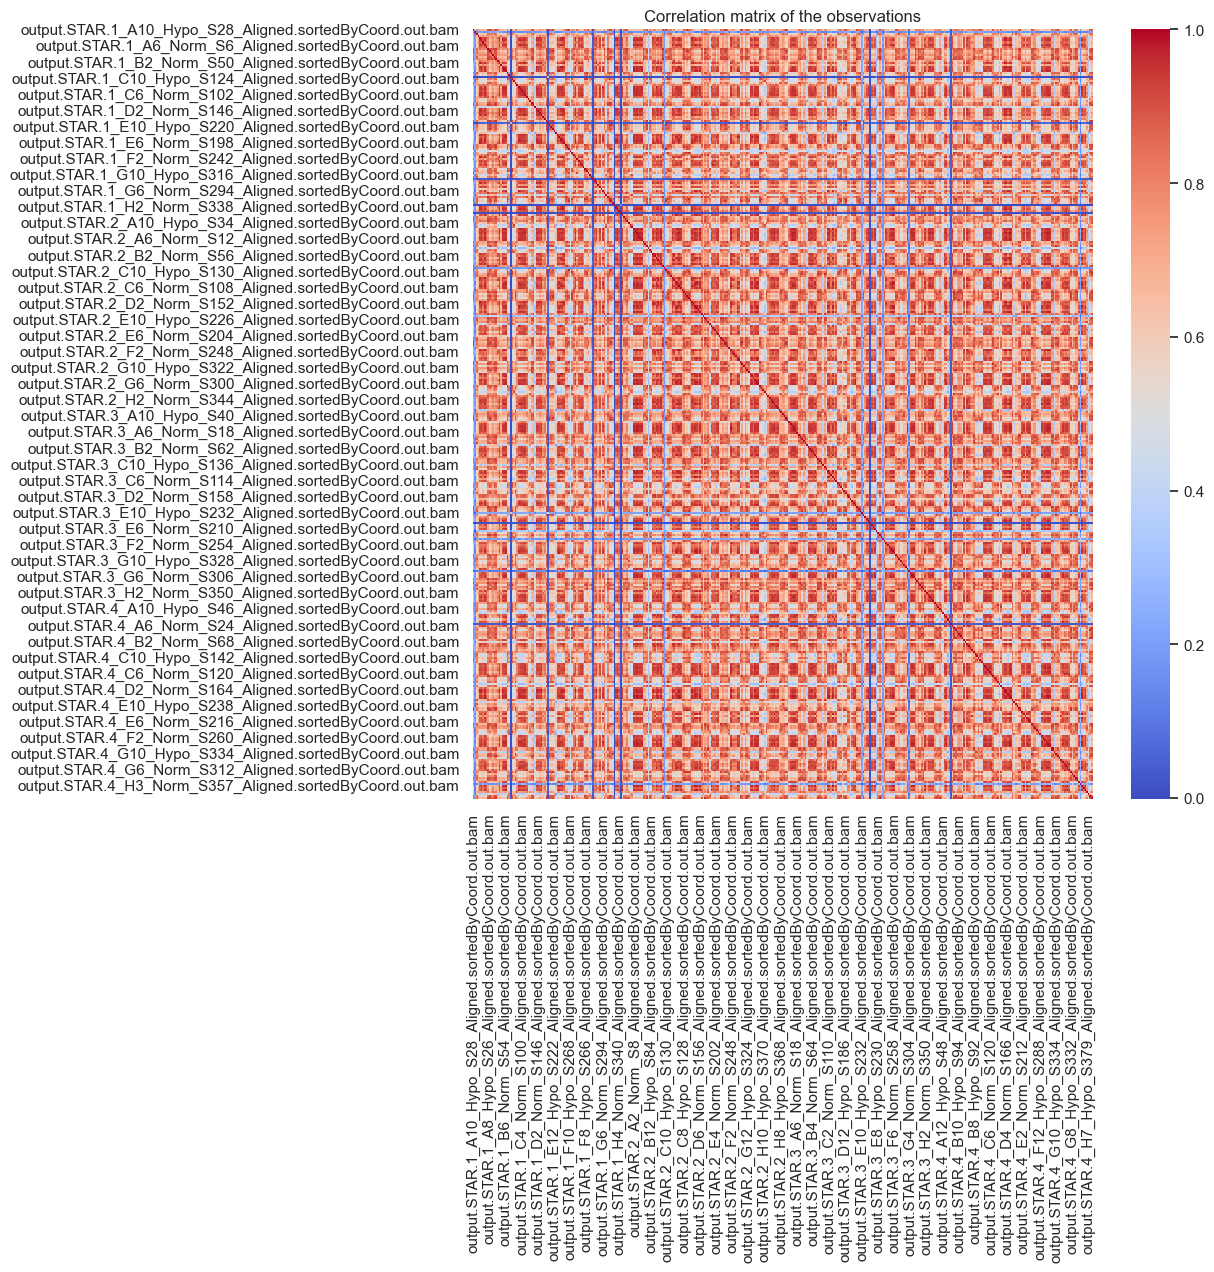

In [15]:
# Check for duplicates
print("Number of duplicates in the dataframe:", merged.duplicated().sum())
# we will now check for duplicates in a broader sense, by checking for observations with high correlation
# we start by computing the correlation matrix of the observations
merged_t = merged.T
correlation_matrix_transpose = merged_t.corr()
# now we plot the correlation matrix
plt.figure(figsize=(10, 10))
sns.heatmap(correlation_matrix_transpose, cmap='coolwarm')
plt.title('Correlation matrix of the observations')
plt.show()

In [16]:
# now we will check for observations with high correlation and drop them
columns_to_keep = []

def add_representative(corr_matrix, col, threshold=0.95):
    corr = corr_matrix[col].drop(col)
    max_corr_id = corr.idxmax()
    max_corr = corr[max_corr_id]
    if max_corr < threshold:
        columns_to_keep.append(col)
        return None
    else:
        if (col not in columns_to_keep) and (max_corr_id not in columns_to_keep):
            columns_to_keep.append(col)
            print('choosing %s as representative for %s with correlation %s' % (col, max_corr_id, max_corr))
            return None
        


for col in merged_t:
    add_representative(correlation_matrix_transpose, col, 0.95)

dropped_cols = [col for col in merged_t if col not in columns_to_keep]

merged_uncorr_obs = merged_t[columns_to_keep].T
print('dropped %s observations' % str(len(dropped_cols)))
merged_uncorr_obs

choosing output.STAR.1_A10_Hypo_S28_Aligned.sortedByCoord.out.bam as representative for output.STAR.2_E9_Hypo_S225_Aligned.sortedByCoord.out.bam with correlation 0.9605716902488991
choosing output.STAR.1_A2_Norm_S2_Aligned.sortedByCoord.out.bam as representative for output.STAR.1_F1_Norm_S241_Aligned.sortedByCoord.out.bam with correlation 0.9754973605458132
choosing output.STAR.1_A3_Norm_S3_Aligned.sortedByCoord.out.bam as representative for output.STAR.1_E5_Norm_S197_Aligned.sortedByCoord.out.bam with correlation 0.980653715556717
choosing output.STAR.1_A5_Norm_S5_Aligned.sortedByCoord.out.bam as representative for output.STAR.4_D6_Norm_S168_Aligned.sortedByCoord.out.bam with correlation 0.983412359539153
choosing output.STAR.1_A7_Hypo_S25_Aligned.sortedByCoord.out.bam as representative for output.STAR.2_B7_Hypo_S79_Aligned.sortedByCoord.out.bam with correlation 0.9655061013299151
choosing output.STAR.1_A8_Hypo_S26_Aligned.sortedByCoord.out.bam as representative for output.STAR.3_A11_

WASH7P  MIR6859-1  WASH9P  \
output.STAR.1_A10_Hypo_S28_Aligned.sortedByCoor...       0          0       1   
output.STAR.1_A11_Hypo_S29_Aligned.sortedByCoor...       0          0       0   
output.STAR.1_A12_Hypo_S30_Aligned.sortedByCoor...       0          0       0   
output.STAR.1_A1_Norm_S1_Aligned.sortedByCoord....       0          0       0   
output.STAR.1_A2_Norm_S2_Aligned.sortedByCoord....       0          0       0   
...                                                    ...        ...     ...   
output.STAR.4_H2_Norm_S356_Aligned.sortedByCoor...       0          0       0   
output.STAR.4_H4_Norm_S358_Aligned.sortedByCoor...       0          0       0   
output.STAR.4_H6_Norm_S360_Aligned.sortedByCoor...       0          0       1   
output.STAR.4_H7_Hypo_S379_Aligned.sortedByCoor...       1          0       1   
output.STAR.4_H9_Hypo_S381_Aligned.sortedByCoor...       1          0       5   

                                                    OR4F29  MTND1P23  \
output.STAR.1_A10_Hypo_S28_Aligned.sortedByCoor...       0         0   
output.STAR.1_A11_Hypo_S29_Aligned.sortedByCoor...       0         0   
output.STAR.1_A12_Hypo_S30_Aligned.sortedByCoor...       0         0   
output.STAR.1_A1_Norm_S1_Aligned.sortedByCoord....       0         0   
output.STAR.1_A2_Norm_S2_Aligned.sortedByCoord....       0         0   
...                                                    ...       ...   
output.STAR.4_H2_Norm_S356_Aligned.sortedByCoor...       0         1   
output.STAR.4_H4_Norm_S358_Aligned.sortedByCoor...       0         0   
output.STAR.4_H6_Norm_S360_Aligned.sortedByCoor...       0         0   
output.STAR.4_H7_Hypo_S379_Aligned.sortedByCoor...       0         0   
output.STAR.4_H9_Hypo_S381_Aligned.sortedByCoor...       0         0   

                                                    MTND2P28  MTCO1P12  \
output.STAR.1_A10_Hypo_S28_Aligned.sortedByCoor...         2         2   
output.STAR.1_A11_Hypo_S29_Aligned.sortedByCoor...         0         0   
output.STAR.1_A12_Hypo_S30_Aligned.sortedByCoor...         1         1   
output.STAR.1_A1_Norm_S1_Aligned.sortedByCoord....         0         0   
output.STAR.1_A2_Norm_S2_Aligned.sortedByCoord....         0         0   
...                                                      ...       ...   
output.STAR.4_H2_Norm_S356_Aligned.sortedByCoor...        45        35   
output.STAR.4_H4_Norm_S358_Aligned.sortedByCoor...         1         0   
output.STAR.4_H6_Norm_S360_Aligned.sortedByCoor...         2         5   
output.STAR.4_H7_Hypo_S379_Aligned.sortedByCoor...         7         0   
output.STAR.4_H9_Hypo_S381_Aligned.sortedByCoor...         5         3   

                                                    MTCO2P12  MTATP8P1  \
output.STAR.1_A10_Hypo_S28_Aligned.sortedByCoor...         0         0   
output.STAR.1_A11_Hypo_S29_Aligned.sortedByCoor...         0         0   
output.STAR.1_A12_Hypo_S30_Aligned.sortedByCoor...         1         0   
output.STAR.1_A1_Norm_S1_Aligned.sortedByCoord....         0         0   
output.STAR.1_A2_Norm_S2_Aligned.sortedByCoord....         0         0   
...                                                      ...       ...   
output.STAR.4_H2_Norm_S356_Aligned.sortedByCoor...         1         2   
output.STAR.4_H4_Norm_S358_Aligned.sortedByCoor...         0         0   
output.STAR.4_H6_Norm_S360_Aligned.sortedByCoor...         5         0   
output.STAR.4_H7_Hypo_S379_Aligned.sortedByCoor...         0         0   
output.STAR.4_H9_Hypo_S381_Aligned.sortedByCoor...         0         0   

                                                    MTATP6P1  ...  MT-TS2  \
output.STAR.1_A10_Hypo_S28_Aligned.sortedByCoor...        29  ...       0   
output.STAR.1_A11_Hypo_S29_Aligned.sortedByCoor...         0  ...       1   
output.STAR.1_A12_Hypo_S30_Aligned.sortedByCoor...        12  ...       0   
output.STAR.1_A1_Norm_S1_Aligned.sortedByCoord....         7  ...       0   
output.STAR.1_A2_Norm_S2_Aligned.sortedByCoord.... 

Also in this case, we actually don't discard any cell.

## Sparsity and NANs

In [17]:
# Check for sparsity
total_elements = merged.shape[0] * merged.shape[1]
print("Total number of elements in the DataFrame:", total_elements)
missing_values = (merged == 0).sum().sum()
print("Total number of 0 values in the DataFrame:", missing_values)
# Calculate the sparsity as the percentage of missing values
sparsity = (missing_values / total_elements) * 100
print("Sparsity of the DataFrame: {:.2f}%".format(sparsity))

Total number of elements in the DataFrame: 8784105
Total number of 0 values in the DataFrame: 5289337
Sparsity of the DataFrame: 60.21%


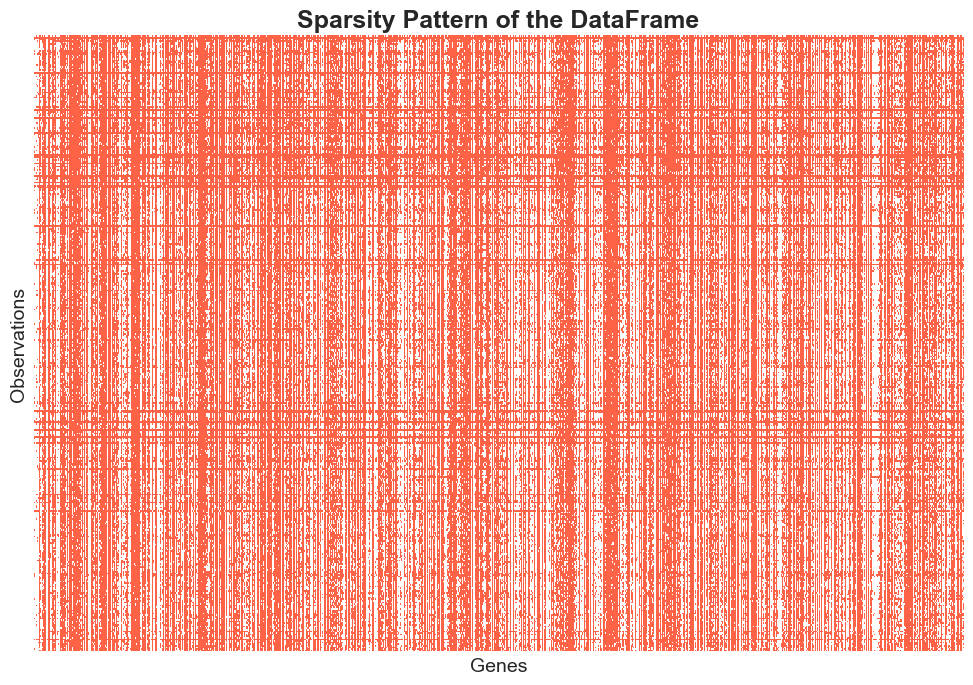

In [18]:
# Create a binary DataFrame indicating missing values (1 for missing, 0 for not missing)
missing_mask = merged == 0

# Set up a custom color palette
colors = ["#FFFFFF", "#FF6347"]  # White for non-missing, red for missing

# Create the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(missing_mask, cmap=sns.color_palette(colors), cbar=False, xticklabels=False, yticklabels=False)

# Add title and labels with custom font size and style
plt.title('Sparsity Pattern of the DataFrame', fontsize=18, fontweight='bold')
plt.xlabel('Genes', fontsize=14)
plt.ylabel('Observations', fontsize=14)

# Remove the spines (borders) of the plot
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.show()

Also in this case, the matrix is very sparse.

In [19]:
## checking colomns that have all missing values
zero_columns = []
for column in merged.columns:
    if (merged[column] == 0).all():
        zero_columns.append(column)
if zero_columns == []:
    print ("There are no columns full of 0")
## check rows all missing values 
zero_rows = []
for index, row in merged.iterrows():
    if (row == 0).all():
        zero_rows.append(index)
if zero_rows == []:
    print("There are no rows full of 0")

There are no columns full of 0
There are no rows full of 0


Number of columns with a high number (>99%) of 0 values: 2546


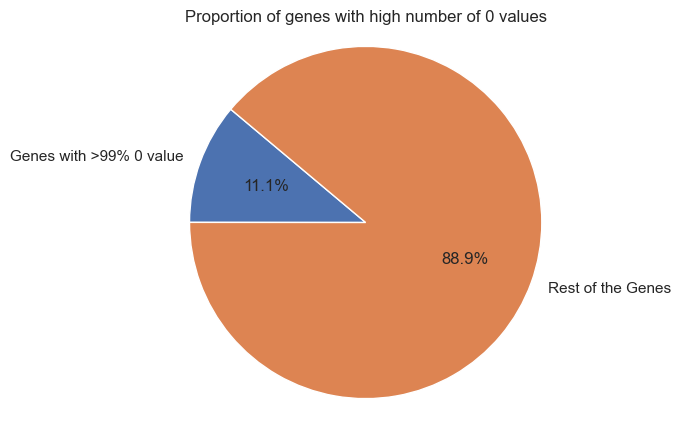

In [20]:
missing_value_columns = []
threshold = 0.99* len(merged.index)
for column in merged.columns:
    missing_count = (merged[column] == 0).sum()
    if missing_count >= threshold:
        missing_value_columns.append(column)

print("Number of columns with a high number (>99%) of 0 values:", len(missing_value_columns))

## Now a plot of the percentage of colomns with a lot of zeros, meaning the genes that are not responsive to the experiment
labels = ['Genes with >99% 0 value', 'Rest of the Genes']
percentages = [(len(missing_value_columns)*100)/len(merged.columns),100-((len(missing_value_columns)*100)/len(merged.columns)) ]  # percentages corresponding to each category

# Plot the pie chart
plt.figure(figsize=(5, 5))  # specify the size of the plot
plt.pie(percentages, labels=labels, autopct='%1.1f%%', startangle=140)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
plt.title('Proportion of genes with high number of 0 values')
plt.show()

NaNs

In [21]:
# Check for NaN values
print("Number of NaN values in the DataFrame:", merged.isna().sum().sum())

Number of NaN values in the DataFrame: 0


## Outliers

#### Boxplot

/Users/filipporonzino/anaconda3/lib/python3.11/site-packages/seaborn/categorical.py:3399: UserWarning: 90.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/filipporonzino/anaconda3/lib/python3.11/site-packages/seaborn/categorical.py:3399: UserWarning: 94.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/filipporonzino/anaconda3/lib/python3.11/site-packages/seaborn/categorical.py:3399: UserWarning: 85.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/filipporonzino/anaconda3/lib/python3.11/site-packages/seaborn/categorical.py:3399: UserWarning: 94.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/filipporonzino/anaconda3/

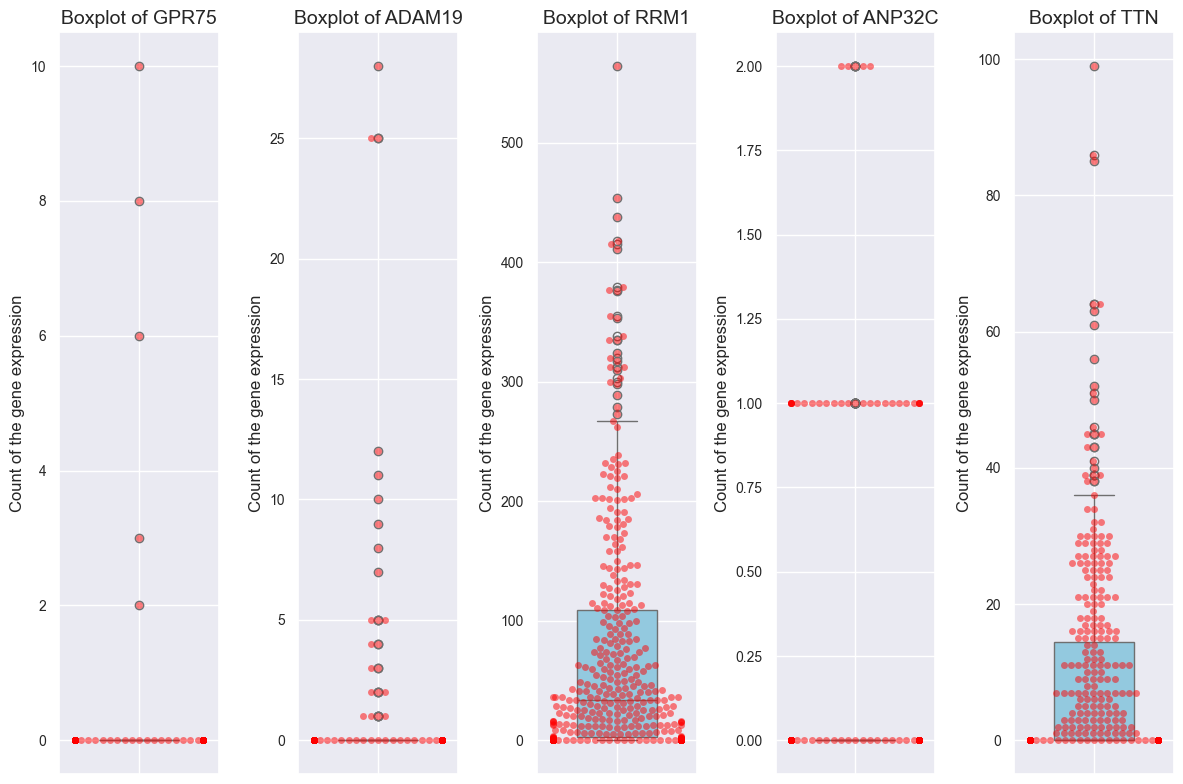

In [22]:
np.random.seed(42)

# Number of boxplots you want to create
num_boxplots = 5

# Randomly select column indices
random_columns = np.random.choice(merged.columns[1:], num_boxplots, replace=False)


plt.figure(figsize=(12, 8))  
for i, column in enumerate(random_columns):
    plt.subplot(1, len(random_columns), i+1)
    
    # Customizing boxplot appearance
    sns.boxplot(y=merged[column], color='skyblue', width=0.5)
    
    # Overlaying swarmplot for better visualization of individual data points
    sns.swarmplot(y=merged[column], color='red', alpha=0.5)
    plt.title(f'Boxplot of {column}', fontsize=14)
    plt.ylabel('Count of the gene expression', fontsize=12)
    plt.xlabel('', fontsize=12)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.grid(True)


plt.tight_layout()
plt.show()

#### IQR

In [23]:
# Outliers with Inter-Quartile Range (IQR) proximity rule for each column
Q1 = merged.quantile(0.25)
Q3 = merged.quantile(0.75)
IQR = Q3 - Q1
outliers = (merged < (Q1 - 1.5 * IQR)) | (merged > (Q3 + 1.5 * IQR))
# Print outliers fora each column
print("Number of outliers in the DataFrame:", outliers.sum())
# Print outliers percentage
outliers_percentage = (outliers.sum().sum() / total_elements) * 100
print("{:.2f}%".format(outliers_percentage))

Number of outliers in the DataFrame: WASH7P       32
MIR6859-1     6
WASH9P       18
OR4F29       14
MTND1P23     18
             ..
MT-CYB       10
MT-TT        27
MT-TP        21
MAFIP        37
Target        0
Length: 22935, dtype: int64
6.19%


#### After Normalization

In [24]:
# now we normalize each column independently
scaler = StandardScaler()

features_df_normalized = merged[merged.columns[:-1]].copy()
features_df_normalized[features_df_normalized.columns] = scaler.fit_transform(features_df_normalized[features_df_normalized.columns])
features_df_normalized.describe()

WASH7P     MIR6859-1        WASH9P        OR4F29      MTND1P23  \
count  3.830000e+02  3.830000e+02  3.830000e+02  3.830000e+02  3.830000e+02   
mean  -4.638007e-17 -1.855203e-17  1.855203e-17 -1.391402e-17 -5.565609e-17   
std    1.001308e+00  1.001308e+00  1.001308e+00  1.001308e+00  1.001308e+00   
min   -2.155182e-01 -1.048746e-01 -5.998576e-01 -1.744196e-01 -2.167786e-01   
25%   -2.155182e-01 -1.048746e-01 -5.998576e-01 -1.744196e-01 -2.167786e-01   
50%   -2.155182e-01 -1.048746e-01 -5.998576e-01 -1.744196e-01 -2.167786e-01   
75%   -2.155182e-01 -1.048746e-01  2.923578e-01 -1.744196e-01 -2.167786e-01   
max    1.435098e+01  1.596191e+01  8.322296e+00  9.368822e+00  8.522823e+00   

           MTND2P28    MTCO1P12      MTCO2P12      MTATP8P1      MTATP6P1  \
count  3.830000e+02  383.000000  3.830000e+02  3.830000e+02  3.830000e+02   
mean   3.710406e-17    0.000000  4.638007e-17 -3.710406e-17 -5.565609e-17   
std    1.001308e+00    1.001308  1.001308e+00  1.001308e+00  1.001308e+00   
min   -8.286406e-01   -0.752102 -5.357467e-01 -2.455385e-01 -8.466527e-01   
25%   -8.286406e-01   -0.752102 -5.357467e-01 -2.455385e-01 -7.589581e-01   
50%   -4.315980e-01   -0.430791 -5.357467e-01 -2.455385e-01 -4.729974e-01   
75%    4.948346e-01    0.372485  4.851040e-01 -2.455385e-01  5.659931e-01   
max    5.126998e+00    5.031489  5.589357e+00  6.471693e+00  5.490236e+00   

       ...         MT-TH        MT-TS2        MT-TL2      MT-ND5  \
count  ...  3.830000e+02  3.830000e+02  3.830000e+02  383.000000   
mean   ...  3.710406e-17  3.710406e-17  3.710406e-17    0.000000   
std    ...  1.001308e+00  1.001308e+00  1.001308e+00    1.001308   
min    ... -5.332347e-01 -4.074384e-01 -7.385861e-01   -1.008284   
25%    ... -5.332347e-01 -4.074384e-01 -7.385861e-01   -0.837671   
50%    ... -5.332347e-01 -4.074384e-01 -5.038322e-01   -0.178031   
75%    ... -3.020788e-02 -4.074384e-01  4.351835e-01    0.528230   
max    ...  7.012167e+00  6.936040e+00  4.426000e+00    7.041304   

             MT-ND6         MT-TE        MT-CYB       MT-TT         MT-TP  \
count  3.830000e+02  3.830000e+02  3.830000e+02  383.000000  3.830000e+02   
mean   9.276015e-17 -3.710406e-17  4.638007e-17    0.000000  3.710406e-17   
std    1.001308e+00  1.001308e+00  1.001308e+00    1.001308  1.001308e+00   
min   -9.279208e-01 -7.609849e-01 -8.143024e-01   -0.618575 -7.500808e-01   
25%   -7.895948e-01 -7.609849e-01 -7.400715e-01   -0.618575 -7.500808e-01   
50%   -2.385581e-01 -3.088796e-01 -5.451510e-01   -0.618575 -3.501537e-01   
75%    4.054517e-01  2.939275e-01  5.773985e-01    0.272080  3.163914e-01   
max    8.151711e+00  6.171296e+00  4.680499e+00    5.912894  6.715224e+00   

              MAFIP  
count  3.830000e+02  
mean  -2.782804e-17  
std    1.001308e+00  
min   -4.496904e-01  
25%   -4.496904e-01  
50%   -4.496904e-01  
75%    6.443325e-02  
max    7.776287e+00  

[8 rows x 22934 columns]

{'whiskers': [<matplotlib.lines.Line2D at 0x2ea2d3850>,
 'caps': [<matplotlib.lines.Line2D at 0x2ea2d4b10>,
 'boxes': [<matplotlib.lines.Line2D at 0x2ea2d3050>],
 'medians': [<matplotlib.lines.Line2D at 0x2ea2d5cd0>],
 'fliers': [<matplotlib.lines.Line2D at 0x2ea2d6550>],
 'means': []}

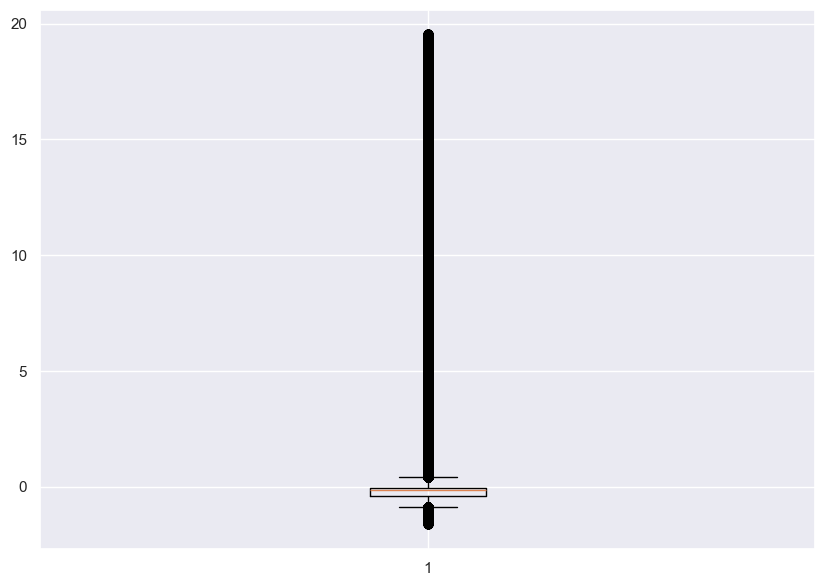

In [25]:
# convert the dataframe to a numpy array, find outliers
features_array_normalized = np.array(features_df_normalized.T)
# still need to find the outliers
fig = plt.figure(figsize=(10, 7))
plt.boxplot(features_array_normalized.flatten())
# here, we notice that most of the data are outliers

## Distribution 

#### Histogram

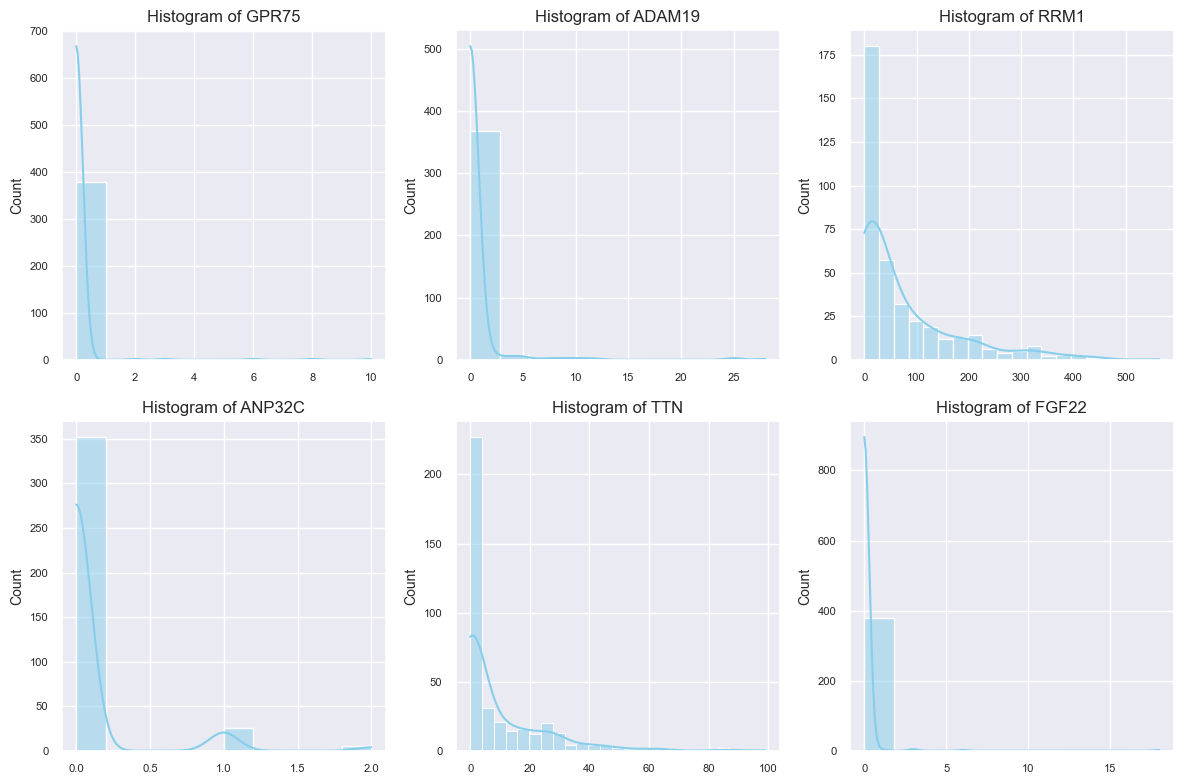

In [26]:
#visualize the distribution of the data through histograms
np.random.seed(42)

# Number of boxplots you want to create
num_boxplots = 6

# Randomly select column indices
random_columns = np.random.choice(merged.columns[1:], num_boxplots, replace=False)



fig = plt.figure(figsize=(12, 8))
for i, column in enumerate(random_columns):  # Adjusted to only consider the first 5 columns
    plt.subplot(2, 3, i+1)  # Adjusted to fit in a 2x3 grid
    sns.histplot(merged[column], kde=True, color='skyblue')
    plt.title(f'Histogram of {column}', fontsize=12)
    plt.xlabel('')
    plt.ylabel('Count', fontsize=10)
    plt.xticks(fontsize=8)
    plt.yticks(fontsize=8)
    plt.grid(True)
plt.tight_layout()
plt.show()


#### Test for Normality

In [27]:
# Calculate skewness for each column in your DataFrame
skewness_values = merged[random_columns].skew()

# Print skewness values
print("Skewness for each selected feature:")
print(skewness_values)

Skewness for each selected feature:
GPR75     11.008745
ADAM19     8.010600
RRM1       1.855538
ANP32C     3.789950
TTN        2.383052
FGF22     16.108174
dtype: float64


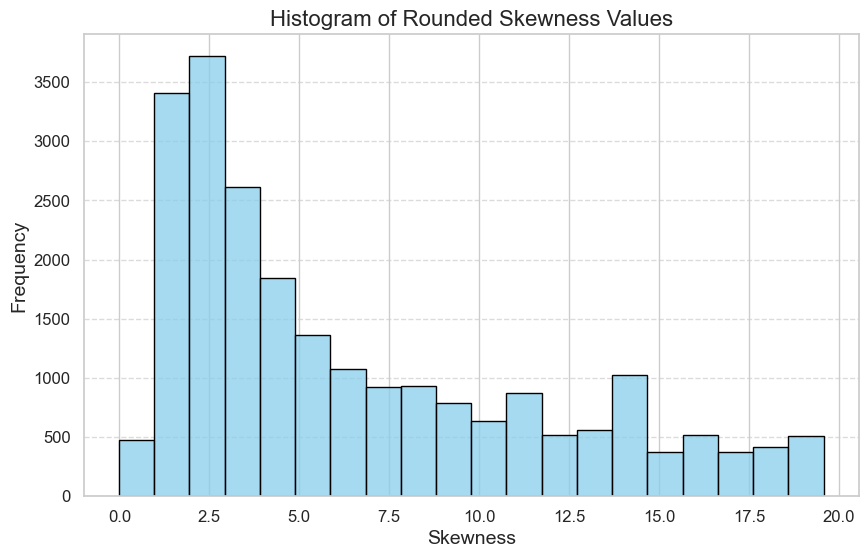

In [28]:
# Calculate skewness for each column in your DataFrame
skewness_values = merged.skew()

# Round the skewness values
rounded_skewness_values = np.round(skewness_values, decimals=2)

# Set seaborn style
sns.set(style="whitegrid")

# Plot a histogram of rounded skewness values
plt.figure(figsize=(10, 6))
sns.histplot(rounded_skewness_values, bins=20, color='skyblue', edgecolor='black')
plt.title('Histogram of Rounded Skewness Values', fontsize=16)
plt.xlabel('Skewness', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [29]:
# Calculate kurtosis for each column in your DataFrame
kurtosis_values = merged[random_columns].kurtosis()

# Print kurtosis values
print("Kurtosis for each feature:")
print(kurtosis_values)

Kurtosis for each feature:
GPR75     127.631126
ADAM19     71.421855
RRM1        3.367925
ANP32C     14.824711
TTN         7.190659
FGF22     281.553685
dtype: float64


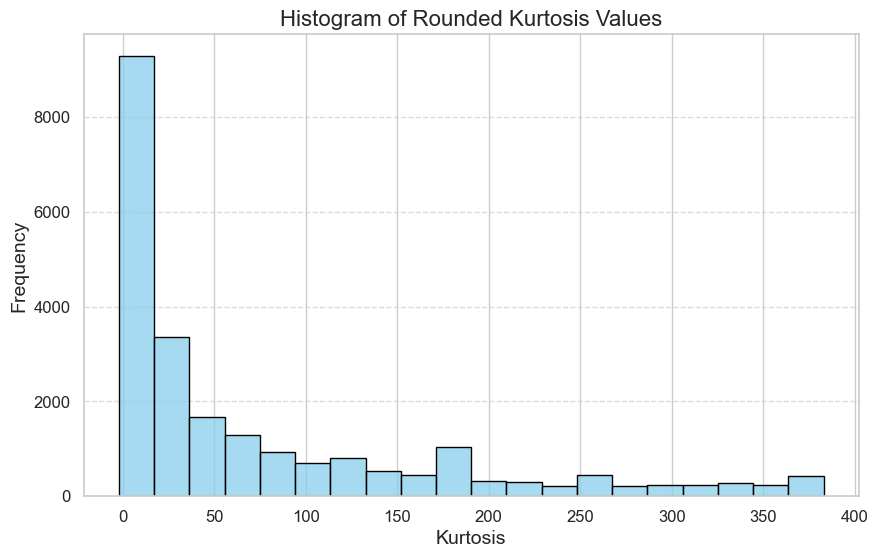

In [30]:
# Calculate kurtosis for each column in your DataFrame
kurtosis_values = merged.kurtosis()

# Round the kurtosis values
rounded_kurtosis_values = np.round(kurtosis_values, decimals=2)

# Set seaborn style
sns.set(style="whitegrid")

# Plot a histogram of rounded kurtosis values
plt.figure(figsize=(10, 6))
sns.histplot(rounded_kurtosis_values, bins=20, color='skyblue', edgecolor='black')
plt.title('Histogram of Rounded Kurtosis Values', fontsize=16)
plt.xlabel('Kurtosis', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

Like the other dataset, we have positive values for skewness and kurtosis. Again let's check for non-normality using Kolmogorov-Smirnov test.

In [31]:
# Test the distribution of the data matrix using Kolmogorov-Smirnov
# Test normality of each feature
def test_distribution_per_feature(data):
    non_normal_count = 0
    for column in data.columns:
        p_value = kstest(data[column], 'norm')[1]
        if p_value < 0.05:
            non_normal_count += 1
    if data.shape[1] == non_normal_count:
        print("All features have non-normal distribution")
    else:
        print("Not all features have non-normal distribution")
        print("Number of features with non-normal distribution:", non_normal_count)

    return non_normal_count

non_normal_count = test_distribution_per_feature(merged)

All features have non-normal distribution


#### Test for other distributions 

In [32]:
# Iterate over columns and perform the test
def test_poissondistribution_per_feature(data):
    poisson_list = [] # initialize list to store features with Poisson distribution
    for column in data.columns:
        observed_values = data[column].values  # values of the column
        support = np.unique(observed_values) # unique values in the column
        mean = observed_values.mean() # mean of the column (we will need this for the Poisson distribution)
        obs_freq = [] # initialize an empty array to store observed frequencies
        for value in support:
            obs_freq.append((observed_values == value).sum()) # count the number of times each unique value appears in the column
        exp_freq = [] # initialize an empty array to store expected frequencies
        for value in support:
            exp_freq.append(poisson.pmf(value, mean) * len(observed_values)) # calculate the expected frequency for each unique value
        # normalize the observed and expected frequencies
        obs_freq = obs_freq / np.sum(obs_freq)
        exp_freq = exp_freq / np.sum(exp_freq)
        
        # perform the chi-square test
        _, p = chisquare(obs_freq, exp_freq)
        
        # if p-value is greater than 0.05, we don't reject the null hypothesis that the data doesn't follow a Poisson distribution
        if p >= 0.05:
            poisson_list.append(column)
    if len(poisson_list) == 0:
        print("All features have non-poisson distribution")
    else:
        print("Some features might have poisson distribution")
        print("Number of features that might have poisson distribution:", len(poisson_list))

    return poisson_list

poisson_columns = test_poissondistribution_per_feature(merged)

/Users/filipporonzino/anaconda3/lib/python3.11/site-packages/scipy/stats/_stats_py.py:7985: RuntimeWarning: divide by zero encountered in divide
  terms = (f_obs_float - f_exp)**2 / f_exp
/Users/filipporonzino/anaconda3/lib/python3.11/site-packages/scipy/stats/_stats_py.py:7985: RuntimeWarning: overflow encountered in divide
  terms = (f_obs_float - f_exp)**2 / f_exp


Some features might have poisson distribution
Number of features that might have poisson distribution: 2886


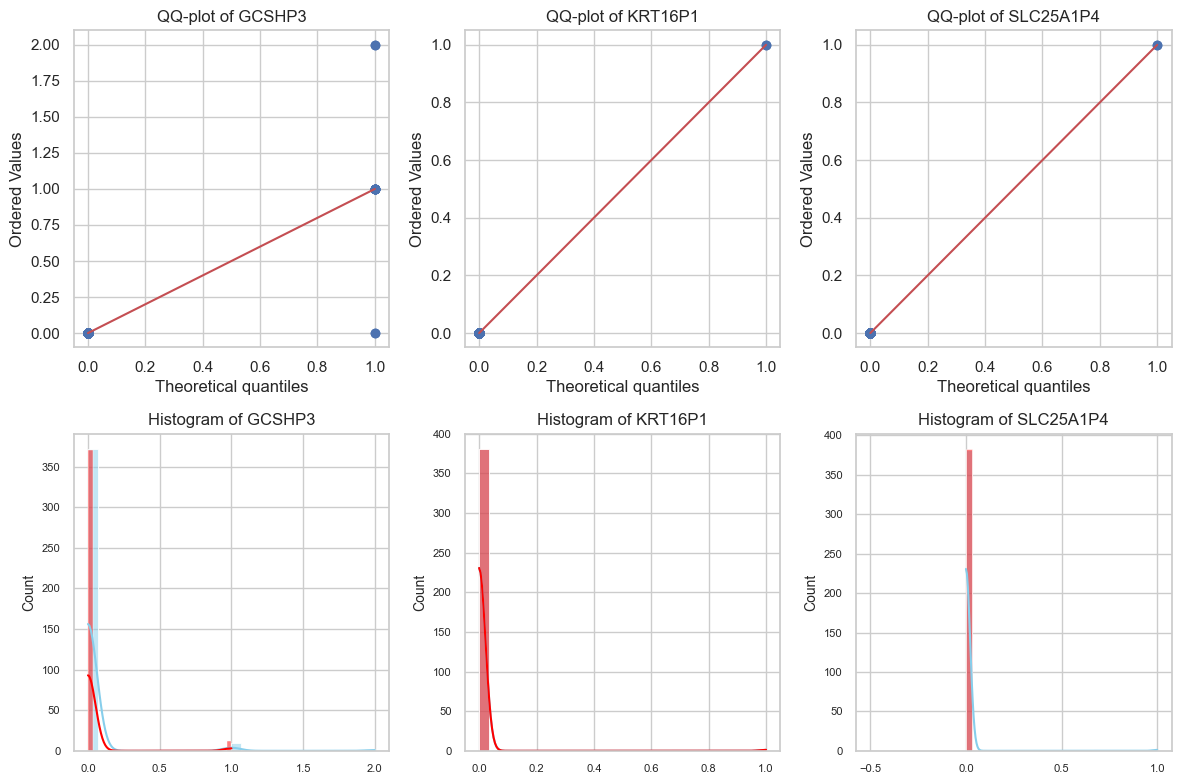

In [33]:
np.random.seed(42)

# Number of boxplots you want to create
num_boxplots = 3

# Randomly select column indices
random_columns = np.random.choice(poisson_columns, num_boxplots, replace=False)

fig = plt.figure(figsize=(12, 8))
for i, column in enumerate(random_columns):  # Adjusted to only consider the first 5 columns
    plt.subplot(2, 3, i+1)  # Adjusted to fit in a 2x3 grid
    observed_values = merged[column].values  # Observed counts from your data
    mean = observed_values.mean()
    poisson_values = np.random.poisson(mean, len(observed_values))
    stats.probplot(observed_values, dist='poisson', sparams=(mean,), plot=plt)
    plt.title(f'QQ-plot of {column}', fontsize=12)

    plt.subplot(2, 3, i+4)
    sns.histplot(observed_values, kde=True, color='skyblue', label='Observed', bins=30)
    sns.histplot(poisson_values, kde=True, color='red', label='Gamma', bins=30)
    plt.title(f'Histogram of {column}', fontsize=12)
    plt.xlabel('')
    plt.ylabel('Count', fontsize=10)
    plt.xticks(fontsize=8)
    plt.yticks(fontsize=8)
    plt.grid(True)
plt.tight_layout()
plt.show()

In [34]:
print('Values of the SLC25A1P4 gene:', observed_values)

Values of the SLC25A1P4 gene: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [35]:
# Iterate over columns and perform the test
def test_negative_binomial_distribution_per_feature(data):
    nbin_list = [] # initialize list to store features with Gamma distribution
    for column in data.columns:
        observed_values = data[column].values  # values of the column
        support = np.unique(observed_values) # unique values in the column
        mean = observed_values.mean() # mean of the column (we will need this for the nbinom distribution)
        var = observed_values.var() # variance of the column (we will need this for the nbinom distribution)
        size = mean ** 2 / (var - mean) # size parameter of the nbinom distribution
        prob = 1 - (mean/var) # probability parameter of the nbinom distribution
        obs_freq = [] # initialize an empty array to store observed frequencies
        for value in support:
            obs_freq.append((observed_values == value).sum()) # count the number of times each unique value appears in the column
        exp_freq = [] # initialize an empty array to store expected frequencies
        for value in support:
            exp_freq.append(nbinom.pmf(value, size, prob) * len(observed_values)) # calculate the expected frequency for each unique value
        # normalize the observed and expected frequencies
        obs_freq = obs_freq / np.sum(obs_freq)
        exp_freq = exp_freq / np.sum(exp_freq)
        
        # perform the chi-square test
        _, p = chisquare(obs_freq, exp_freq)
        
        # if p-value is greater than 0.05, we don't reject the null hypothesis that the data doesn't follow a negative binomial distribution
        if p >= 0.05:
            nbin_list.append(column)
    if len(nbin_list) == 0:
        print("All features have non-Negative Binomial distribution")
    else:
        print("Some features might have Negative Binomial distribution")
        print("Number of features with Negative Binomial distribution:", len(nbin_list))

    return nbin_list

negative_binomial_columns = test_negative_binomial_distribution_per_feature(merged)

/Users/filipporonzino/anaconda3/lib/python3.11/site-packages/scipy/stats/_stats_py.py:7985: RuntimeWarning: divide by zero encountered in divide
  terms = (f_obs_float - f_exp)**2 / f_exp
/Users/filipporonzino/anaconda3/lib/python3.11/site-packages/scipy/stats/_stats_py.py:7985: RuntimeWarning: overflow encountered in divide
  terms = (f_obs_float - f_exp)**2 / f_exp
/Users/filipporonzino/.local/lib/python3.11/site-packages/numpy/core/_methods.py:49: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
/var/folders/l4/fwn11xh17pb5ryvd5h_w9p8r0000gn/T/ipykernel_15869/4107845048.py:19: RuntimeWarning: invalid value encountered in divide
  exp_freq = exp_freq / np.sum(exp_freq)


Some features might have Negative Binomial distribution
Number of features with Negative Binomial distribution: 2814


Percentage of zeros in the gene KCNG4: 99.0 %
Percentage of zeros in the gene RPL35AP35: 98.0 %
Percentage of zeros in the gene SNORA29: 97.0 %


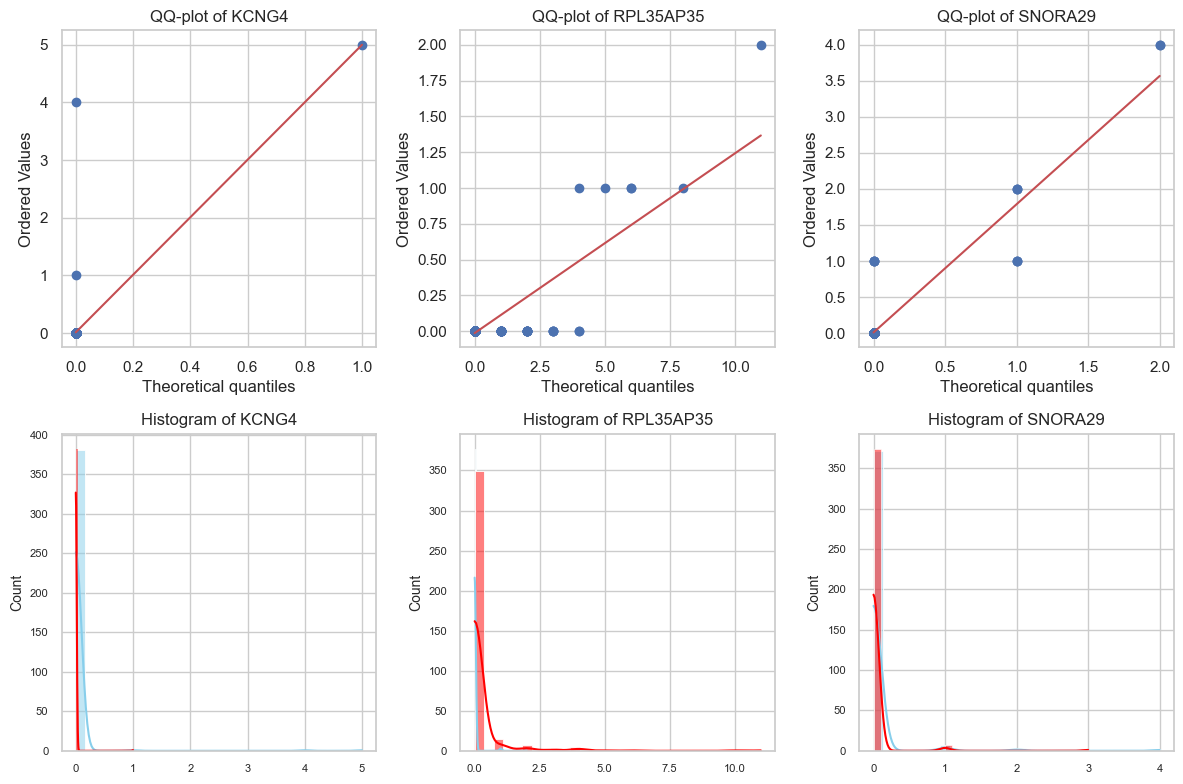

In [36]:
# now we plot the hist of the nbin columns
#now we visualize the empirical distribution against the negative binomial distribution for some columns

np.random.seed(100)

# Number of boxplots you want to create
num_boxplots = 3

# Randomly select column indices
random_columns = np.random.choice(negative_binomial_columns, num_boxplots, replace=False)

fig = plt.figure(figsize=(12, 8))
for i, column in enumerate(random_columns):  # Adjusted to only consider the first 5 columns
    plt.subplot(2, 3, i+1)  # Adjusted to fit in a 2x3 grid
    observed_values = merged[column].values  # Observed counts from your data
    print(f'Percentage of zeros in the gene {column}:', np.round((observed_values == 0).sum() / len(observed_values) * 100), '%')
    mean = observed_values.mean() # mean of the column (we will need this for the nbinom distribution)
    var = observed_values.var() # variance of the column (we will need this for the nbinom distribution)
    # HERE WE ARE CHEATING WITH THE ABSOLUTE VALUE AND THE "NORMALIZATION" OF THE PROB
    size = abs(mean ** 2 / (var - mean)) # size parameter of the nbinom distribution
    prob = 1 - (mean/var) # probability parameter of the nbinom distribution
    if prob < 0:
        prob = 0
    elif prob > 1:
        prob = 1
    stats.probplot(observed_values, dist='nbinom', sparams=(size,prob), plot=plt)
    plt.title(f'QQ-plot of {column}', fontsize=12)

    plt.subplot(2, 3, i+4)
    plt.title(f'QQ-plot of {column}', fontsize=12)
    nbinom_values = np.random.negative_binomial(size, prob, len(observed_values))
    sns.histplot(observed_values, kde=True, color='skyblue', label='Observed', bins=30)
    sns.histplot(nbinom_values, kde=True, color='red', label='Negative Binomial', bins=30)
    plt.title(f'Histogram of {column}', fontsize=12)
    plt.xlabel('')
    plt.ylabel('Count', fontsize=10)
    plt.xticks(fontsize=8)
    plt.yticks(fontsize=8)
    plt.grid(True)
plt.tight_layout()
plt.show()

Everything like in the previous dataset, we see that the test is likely been tricked by the high number of zeros in the dataset.

## Correlation 

#### Genes Correlation

In [37]:
# We will use pytorch correlation matrix to calculate the correlation matrix usint torch.corrcoef
# Correlation matrix between the genes (features)

# Convert the DataFrame to a PyTorch tensor
data_tensor = th.tensor(merged.values).T
# Calculate the correlation matrix
correlation_matrix = th.corrcoef(data_tensor)
print(correlation_matrix)

# Compute the midpoint
midpoint = (correlation_matrix.max() - correlation_matrix.min()) / 2 + correlation_matrix.min()
# Print the size of the correlation matrix
print("Size of the correlation matrix: ", correlation_matrix.shape)
# Print average and minimum correlation values
print("Average correlation between cells: ", float(midpoint))
print("Minimum correlation between cells: ", float(correlation_matrix.min()), "\n")

tensor([[ 1.0000,  0.0453,  0.3005,  ...,  0.1927,  0.0378, -0.0724],
        [ 0.0453,  1.0000,  0.0073,  ...,  0.0136, -0.0310,  0.1046],
        [ 0.3005,  0.0073,  1.0000,  ...,  0.0275,  0.0395, -0.1705],
        ...,
        [ 0.1927,  0.0136,  0.0275,  ...,  1.0000,  0.0958,  0.1717],
        [ 0.0378, -0.0310,  0.0395,  ...,  0.0958,  1.0000, -0.1770],
        [-0.0724,  0.1046, -0.1705,  ...,  0.1717, -0.1770,  1.0000]])
Size of the correlation matrix:  torch.Size([22935, 22935])
Average correlation between cells:  0.1962929368019104
Minimum correlation between cells:  -0.6074140667915344 



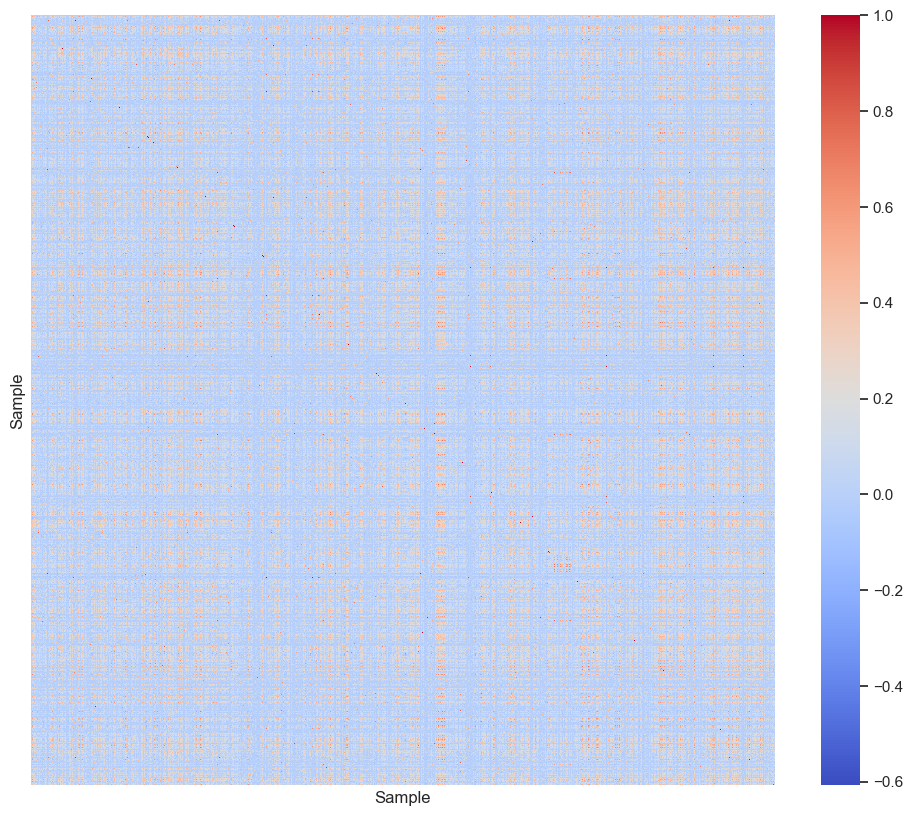

In [38]:
plt.figure(figsize=(12,10))
sns.heatmap(correlation_matrix, cmap='coolwarm', yticklabels = False, xticklabels = False)
plt.xlabel('Sample')
plt.ylabel('Sample')
plt.show()

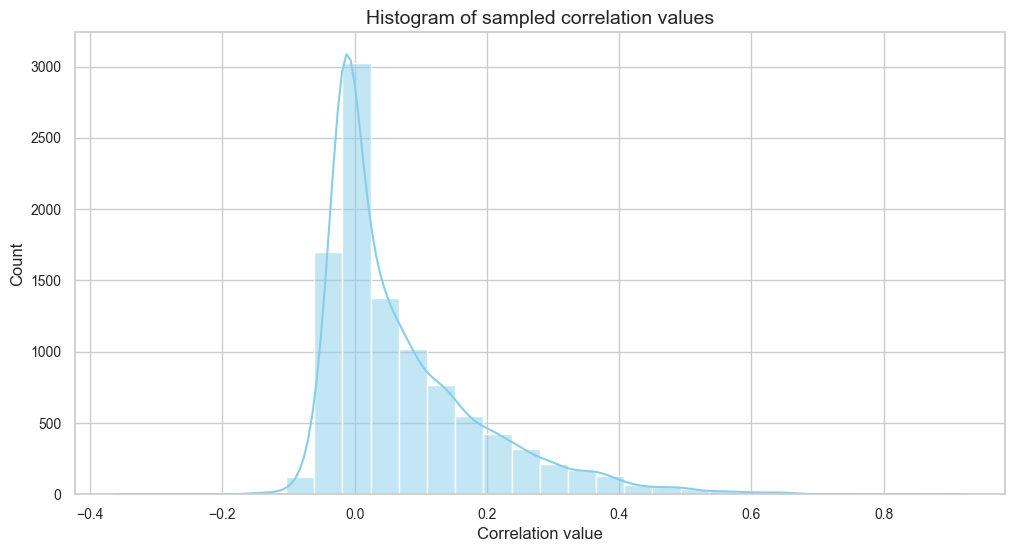

In [39]:
# Flatten the correlation matrix
correlation_values = correlation_matrix.flatten()

# Randomly sample a subset of correlation values
sample_size = 10000  # Adjust sample size as needed
sampled_correlation_values = np.random.choice(correlation_values, size=sample_size)

# Plot the histogram of the sampled correlation values
plt.figure(figsize=(12, 6))
sns.histplot(sampled_correlation_values, kde=True, color='skyblue', bins=30)
plt.title('Histogram of sampled correlation values', fontsize=14)
plt.xlabel('Correlation value', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(True)
plt.show()

In [46]:
# Sample 1000 columns randomly from merged
sampled_columns = np.random.choice(merged.columns, 1000, replace=False)
sampled_data = merged[sampled_columns]

# Compute the correlation matrix with numpy
correlation_matrix_sample = sampled_data.corr()

# Drop diagonal values (self-correlations)
np.fill_diagonal(correlation_matrix_sample.values, np.nan)

# Extract the top 5 correlated pairs
top_5_correlated_pairs = correlation_matrix_sample.unstack().sort_values(ascending=False).dropna().head(10)

# Delete the second, fouth, sixth, etc. elements to avoid duplicates
top_5_correlated_pairs = top_5_correlated_pairs.iloc[::2]

print("Top 5 correlated pairs (excluding diagonal):")
print(top_5_correlated_pairs)
#we convert top_5_correlated_pairs to a dataframe
top_5_correlated_pairs = top_5_correlated_pairs.to_frame().reset_index()
top_5_correlated_pairs.columns = ['Gene 1', 'Gene 2', 'Correlation']

Top 5 correlated pairs (excluding diagonal):
PCDHGA5    PCDHGB2        0.995137
CCDC190    RNU6-645P      0.993833
FLNC       MSR1           0.992458
LINC01366  B3GALT1-AS1    0.975641
PARP14     OAS2           0.972963
dtype: float64


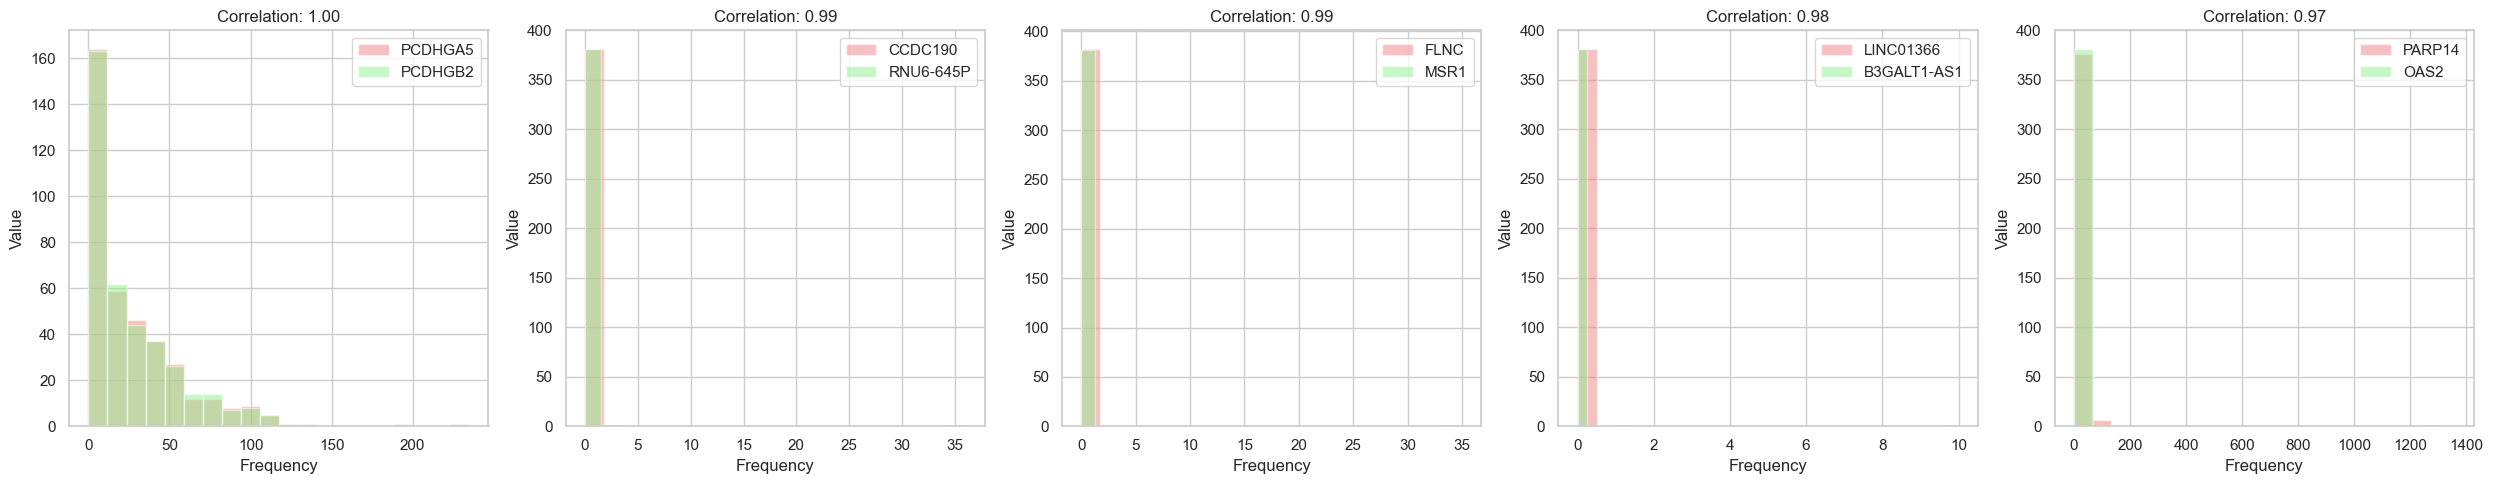

In [47]:
fig, axs = plt.subplots(1, 5, figsize=(25, 5))  # Adjusted figsize for better visualization
for i, (gene1, gene2, corr) in enumerate(top_5_correlated_pairs.values):
    axs[i].hist(merged[gene1], color='lightcoral', alpha=0.5, bins=20, orientation='vertical')
    axs[i].hist(merged[gene2], color='lightgreen', alpha=0.5, bins=20, orientation='vertical')
    axs[i].set_xlabel('Frequency')
    axs[i].set_ylabel('Value')
    axs[i].set_title(f'Correlation: {corr:.2f}')
    axs[i].legend([gene1, gene2])
    
plt.tight_layout()
plt.show()

Like in the previous dataset, we see that exceptional values of correlations are given by the high number of zeros in the dataset, but this time we notice that there are 2 genes, PCDHGA5PC and PCDHGB2, which are actually correlated almost perfectly.
Biologically speaking, PCDHGA5PC and PCDHGB2 are both members of the protocadherin gene family, so it makes sense that they are highly correlated. (Sometimes) numbers don't lie!

#### More on cells correlation

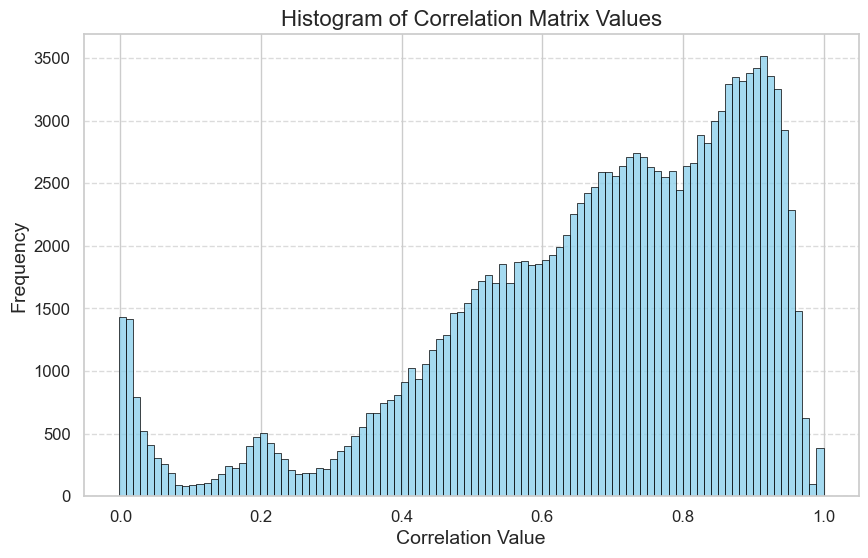

In [ ]:
# Correlation between cells (samples)
# Plot histogram of the values to see the distribution
data_tensor = th.tensor(merged.values)
correlation_matrix_transpose = th.corrcoef(data_tensor)
plt.figure(figsize=(10, 6))
sns.histplot(correlation_matrix_transpose.flatten(), bins=100, color='skyblue', edgecolor='black')
plt.title('Histogram of Correlation Matrix Values', fontsize=16)
plt.xlabel('Correlation Value', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

(383, 383)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


[]

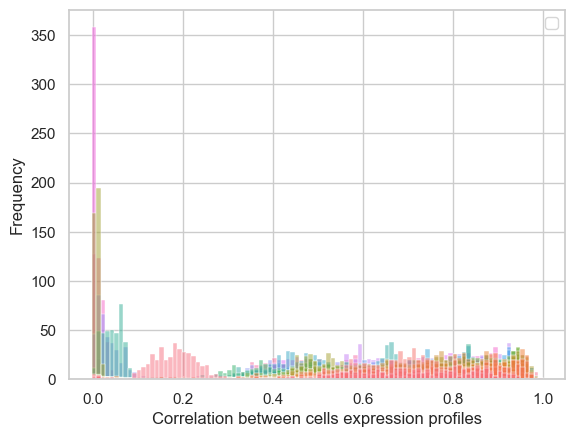

In [ ]:
# We now can plot the distribution of the correlation between gene expression profiles using a 
# histogram (we do it on the first ten variables)

correlation_matrix = pd.DataFrame(correlation_matrix_transpose)
print(correlation_matrix.shape)
c_subset = correlation_matrix.iloc[:,:100]
sns.histplot(c_subset,bins=100)
plt.legend().set_visible(True)
plt.ylabel('Frequency')
plt.xlabel('Correlation between cells expression profiles')
plt.plot()

We see a behaviour similar to the previous dataset.

In [ ]:
# from c_subset we extract the cells with lower correlation, and to do so we create a list with the 
# sum of the correlation of each cell with the rest of the cells
correlation_sum = c_subset.sum(axis=0)
#we take the 3 cells with the lowest correlation
low_correlation_cells = correlation_sum.nsmallest(3)
print('Cells with the lowest correlation:', merged.iloc[low_correlation_cells.index].index)

Cells with the lowest correlation: Index(['output.STAR.1_H1_Norm_S337_Aligned.sortedByCoord.out.bam',
       'output.STAR.1_H5_Norm_S341_Aligned.sortedByCoord.out.bam',
       'output.STAR.1_B9_Hypo_S75_Aligned.sortedByCoord.out.bam'],
      dtype='object')


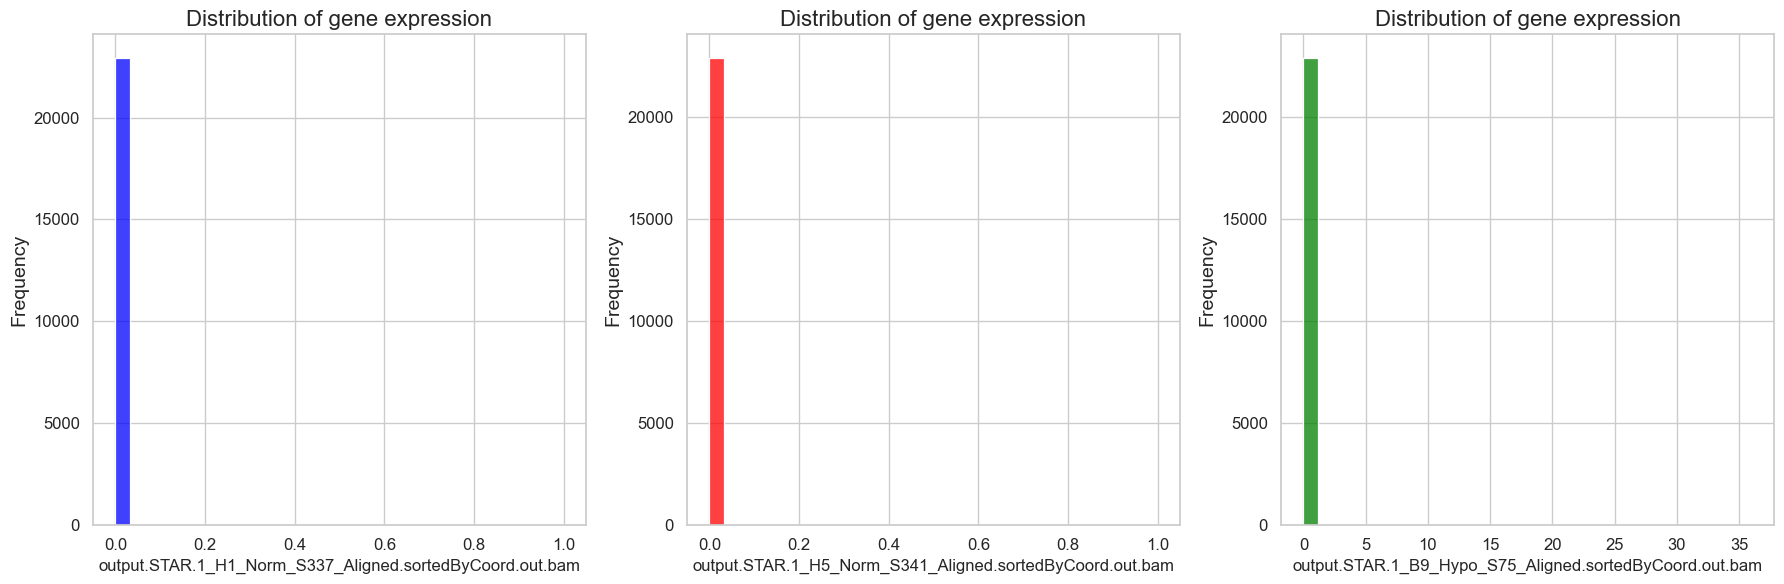

Percentage of zeros in the cell 87: 99.99127970350992 %
Percentage of zeros in the cell 91: 99.89971659036408 %
Percentage of zeros in the cell 23: 99.74711140178766 %


In [ ]:
# Create subplots separately for each cell
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Plot histograms for each cell
sns.histplot(merged.iloc[low_correlation_cells.index[0]], bins=30, color='blue', ax=axs[0])
axs[0].set_title(f'Distribution of gene expression', fontsize=16)
axs[0].set_ylabel('Frequency', fontsize=14)
axs[0].tick_params(axis='both', which='both', labelsize=12)
axs[0].grid(True)

sns.histplot(merged.iloc[low_correlation_cells.index[1]], bins=30, color='red', ax=axs[1])
axs[1].set_title(f'Distribution of gene expression', fontsize=16)
axs[1].set_ylabel('Frequency', fontsize=14)
axs[1].tick_params(axis='both', which='both', labelsize=12)
axs[1].grid(True)

sns.histplot(merged.iloc[low_correlation_cells.index[2]], bins=30, color='green', ax=axs[2])
axs[2].set_title(f'Distribution of gene expression', fontsize=16)
axs[2].set_ylabel('Frequency', fontsize=14)
axs[2].tick_params(axis='both', which='both', labelsize=12)
axs[2].grid(True)

plt.tight_layout()
plt.show()

for cell in low_correlation_cells.index:
    observed_values = merged.iloc[cell]
    print(f'Percentage of zeros in the cell {cell}:', ((observed_values == 0).sum() / len(observed_values) * 100), '%')

In [ ]:
merged_norm = merged[merged['Target'] == 0]
merged_hypo = merged[merged['Target'] == 1]

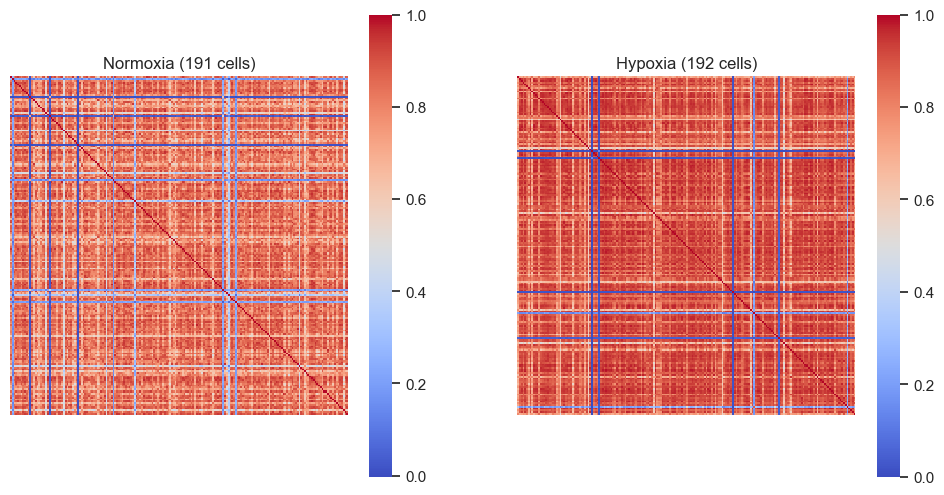

Shape of correlation matrix for normoxia: torch.Size([191, 191])
Shape of correlation matrix for hypoxia: torch.Size([192, 192])
Size of the correlation matrix:  torch.Size([191, 191])
Average correlation between cells:  0.4990430772304535
Minimum correlation between cells:  -0.0019138207426294684 

Size of the correlation matrix:  torch.Size([192, 192])
Average correlation between cells:  0.49994322657585144
Minimum correlation between cells:  -0.00011357459879945964 



In [ ]:
# Transform the data to a tensor
data_tensor_norm = th.tensor(merged_norm.values)
data_tensor_hypo = th.tensor(merged_hypo.values)

# Calculate the correlation matrices
correlation_matrix_norm = th.corrcoef(data_tensor_norm)
correlation_matrix_hypo = th.corrcoef(data_tensor_hypo)

# Plot the correlation matrices with subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
sns.heatmap(correlation_matrix_norm, cmap='coolwarm', yticklabels = False, xticklabels = False, ax=axs[0], square=True)
sns.heatmap(correlation_matrix_hypo, cmap='coolwarm', yticklabels = False, xticklabels = False, ax=axs[1], square=True)
# Set titles with number of genes that are norm or hypo
axs[0].set_title(f'Normoxia ({merged_norm.shape[0]} cells)')
axs[1].set_title(f'Hypoxia ({merged_hypo.shape[0]} cells)')
plt.show() 

# Check shape of correlation matrices
print("Shape of correlation matrix for normoxia:", correlation_matrix_norm.shape)
print("Shape of correlation matrix for hypoxia:", correlation_matrix_hypo.shape)

# Compute the midpoint for Norm
midpoint_norm = (correlation_matrix_norm.max() - correlation_matrix_norm.min()) / 2 + correlation_matrix_norm.min()
# Print the size of the correlation matrix
print("Size of the correlation matrix: ", correlation_matrix_norm.shape)
# Print average and minimum correlation values
print("Average correlation between cells: ", float(midpoint_norm))
print("Minimum correlation between cells: ", float(correlation_matrix_norm.min()), "\n")

# Compute the midpoint for Hypo
midpoint_hypo = (correlation_matrix_hypo.max() - correlation_matrix_hypo.min()) / 2 + correlation_matrix_hypo.min()
# Print the size of the correlation matrix
print("Size of the correlation matrix: ", correlation_matrix_hypo.shape)
# Print average and minimum correlation values
print("Average correlation between cells: ", float(midpoint_hypo))
print("Minimum correlation between cells: ", float(correlation_matrix_hypo.min()), "\n")

Also in this case no relevant differences in correlation matrix is observed between the two datasets.

## Description of the Original Dataset

We are now interested in doing the same data analysis that we did for the transposed dataset for the original dataset, i.e. we are interested in the description of the data with rows as genes and columns as cells.

In [ ]:
# we simply transpose again the dataframe (now we have cells as columns)
print("Dataframe dimension before transpose:", df_seq_MUnfilt.shape)
df_seq_MUnfilt = df_seq_MUnfilt.T
print("Dataframe dimension after transpose:", df_seq_MUnfilt.shape)
df_seq_MUnfilt.head(5)

Dataframe dimension before transpose: (383, 22934)
Dataframe dimension after transpose: (22934, 383)


output.STAR.1_A10_Hypo_S28_Aligned.sortedByCoord.out.bam  \
WASH7P                                                     0          
MIR6859-1                                                  0          
WASH9P                                                     1          
OR4F29                                                     0          
MTND1P23                                                   0          

           output.STAR.1_A11_Hypo_S29_Aligned.sortedByCoord.out.bam  \
WASH7P                                                     0          
MIR6859-1                                                  0          
WASH9P                                                     0          
OR4F29                                                     0          
MTND1P23                                                   0          

           output.STAR.1_A12_Hypo_S30_Aligned.sortedByCoord.out.bam  \
WASH7P                                                     0          
MIR6859-1                                                  0          
WASH9P                                                     0          
OR4F29                                                     0          
MTND1P23                                                   0          

           output.STAR.1_A1_Norm_S1_Aligned.sortedByCoord.out.bam  \
WASH7P                                                     0        
MIR6859-1                                                  0        
WASH9P                                                     0        
OR4F29                                                     0        
MTND1P23                                                   0        

           output.STAR.1_A2_Norm_S2_Aligned.sortedByCoord.out.bam  \
WASH7P                                                     0        
MIR6859-1                                                  0        
WASH9P                                                     0        
OR4F29                                                     0        
MTND1P23                                                   0        

           output.STAR.1_A3_Norm_S3_Aligned.sortedByCoord.out.bam  \
WASH7P                                                     0        
MIR6859-1                                                  0        
WASH9P                                                     1        
OR4F29                                                     0        
MTND1P23                                                   0        

           output.STAR.1_A4_Norm_S4_Aligned.sortedByCoord.out.bam  \
WASH7P                                                     0        
MIR6859-1                                                  0        
WASH9P                                                    10        
OR4F29                                                     0        
MTND1P23                                                   0        

           output.STAR.1_A5_Norm_S5_Aligned.sortedByCoord.out.bam  \
WASH7P                                                     0        
MIR6859-1                                                  0        
WASH9P                                                     1        
OR4F29                                                     0        
MTND1P23                                                   0        

           output.STAR.1_A6_Norm_S6_Aligned.sortedByCoord.out.bam  \
WASH7P                                                     0        
MIR6859-1                                                  0        
WASH9P                                                     0        
OR4F29                                                     0        
MTND1P23                                                   0        

           output.STAR.1_A7_Hypo_S25_Aligned.sortedByCoord.out.bam  ...  \
WASH7P                                                     0        ...   
MIR6859-1                                                  0        ...   
WASH9P         

In [ ]:

print("Missing values in the dataframe by columns:", df_seq_MUnfilt.isnull().sum())
print("Missing values in the whole dataframe:", df_seq_MUnfilt.isna().sum().sum())

Missing values in the dataframe by columns: output.STAR.1_A10_Hypo_S28_Aligned.sortedByCoord.out.bam    0
output.STAR.1_A11_Hypo_S29_Aligned.sortedByCoord.out.bam    0
output.STAR.1_A12_Hypo_S30_Aligned.sortedByCoord.out.bam    0
output.STAR.1_A1_Norm_S1_Aligned.sortedByCoord.out.bam      0
output.STAR.1_A2_Norm_S2_Aligned.sortedByCoord.out.bam      0
                                                           ..
output.STAR.4_H5_Norm_S359_Aligned.sortedByCoord.out.bam    0
output.STAR.4_H6_Norm_S360_Aligned.sortedByCoord.out.bam    0
output.STAR.4_H7_Hypo_S379_Aligned.sortedByCoord.out.bam    0
output.STAR.4_H8_Hypo_S380_Aligned.sortedByCoord.out.bam    0
output.STAR.4_H9_Hypo_S381_Aligned.sortedByCoord.out.bam    0
Length: 383, dtype: int64
Missing values in the whole dataframe: 0


In [ ]:
df_seq_MUnfilt.describe()

output.STAR.1_A10_Hypo_S28_Aligned.sortedByCoord.out.bam  \
count                                       22934.000000          
mean                                           40.817651          
std                                           465.709940          
min                                             0.000000          
25%                                             0.000000          
50%                                             0.000000          
75%                                            17.000000          
max                                         46744.000000          

       output.STAR.1_A11_Hypo_S29_Aligned.sortedByCoord.out.bam  \
count                                       22934.000000          
mean                                            0.012253          
std                                             0.207726          
min                                             0.000000          
25%                                             0.000000          
50%                                             0.000000          
75%                                             0.000000          
max                                            14.000000          

       output.STAR.1_A12_Hypo_S30_Aligned.sortedByCoord.out.bam  \
count                                       22934.000000          
mean                                           86.442400          
std                                          1036.572689          
min                                             0.000000          
25%                                             0.000000          
50%                                             0.000000          
75%                                             5.000000          
max                                         82047.000000          

       output.STAR.1_A1_Norm_S1_Aligned.sortedByCoord.out.bam  \
count                                       22934.000000        
mean                                            1.024636        
std                                             6.097362        
min                                             0.000000        
25%                                             0.000000        
50%                                             0.000000        
75%                                             0.000000        
max                                           289.000000        

       output.STAR.1_A2_Norm_S2_Aligned.sortedByCoord.out.bam  \
count                                       22934.000000        
mean                                           14.531351        
std                                           123.800530        
min                                             0.000000        
25%                                             0.000000        
50%                                             0.000000        
75%                                             7.000000        
max                                         10582.000000        

       output.STAR.1_A3_Norm_S3_Aligned.sortedByCoord.out.bam  \
count                                       22934.000000        
mean                                           56.213613        
std                                           503.599145        
min                                             0.000000        
25%                                             0.000000        
50%                                             0.000000        
75%                                            23.000000        
max                                         46856.000000        

       output.STAR.1_A4_Norm_S4_Aligned.sortedByCoord.out.bam  \
count                                       22934.000000        
mean                                           75.397183        
std                                           430.471519        
min                                             0.000000        
25%                                             0.000000        
50%                                            

In [15]:
# Just renaming
mergedT = df_seq_MUnfilt

In [ ]:
# PLOT OUTLIERS 

We check for outliers with the same method used for the trasposed dataset.

In [ ]:
# Outliers with Inter-Quartile Range (IQR) proximity rule for each column
Q1 = mergedT.quantile(0.25)
Q3 = mergedT.quantile(0.75)
IQR = Q3 - Q1
outliers = (mergedT < (Q1 - 1.5 * IQR)) | (mergedT > (Q3 + 1.5 * IQR))
# Print outliers fora each column
print("Number of outliers in the DataFrame:", outliers.sum())
# Print outliers percentage
outliers_percentage = (outliers.sum().sum() / total_elements) * 100
print("{:.2f}%".format(outliers_percentage))

Number of outliers in the DataFrame: output.STAR.1_A10_Hypo_S28_Aligned.sortedByCoord.out.bam    3751
output.STAR.1_A11_Hypo_S29_Aligned.sortedByCoord.out.bam     188
output.STAR.1_A12_Hypo_S30_Aligned.sortedByCoord.out.bam    5329
output.STAR.1_A1_Norm_S1_Aligned.sortedByCoord.out.bam      4739
output.STAR.1_A2_Norm_S2_Aligned.sortedByCoord.out.bam      3511
                                                            ... 
output.STAR.4_H5_Norm_S359_Aligned.sortedByCoord.out.bam    3286
output.STAR.4_H6_Norm_S360_Aligned.sortedByCoord.out.bam    3490
output.STAR.4_H7_Hypo_S379_Aligned.sortedByCoord.out.bam    3410
output.STAR.4_H8_Hypo_S380_Aligned.sortedByCoord.out.bam    3306
output.STAR.4_H9_Hypo_S381_Aligned.sortedByCoord.out.bam    3250
Length: 383, dtype: int64
14.45%


Now we analyze distribution of the transpose dataset (rows are genes)

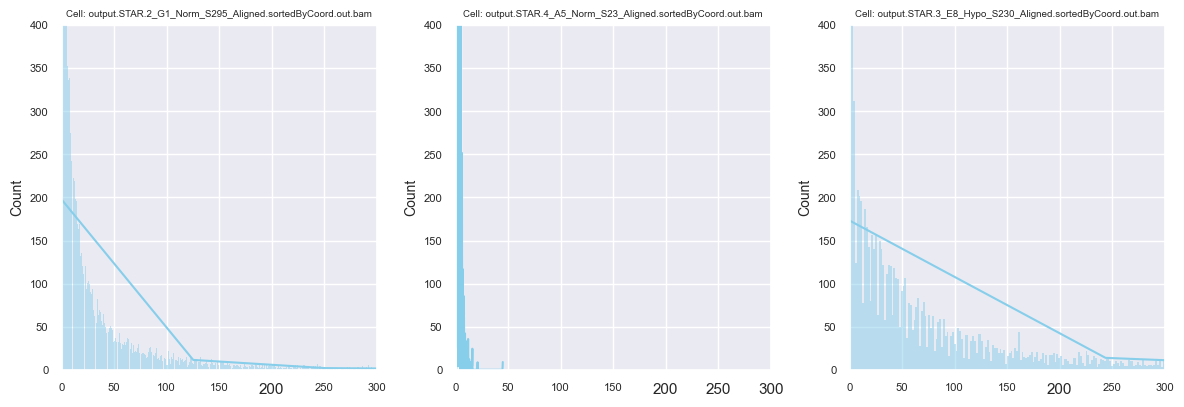

In [24]:
np.random.seed(45)  # Set random seed for reproducibility

# Number of histograms you want to create
num_histograms = 3

# Randomly select column indices
random_columns = np.random.choice(mergedT.columns[1:], num_histograms, replace=False)

fig = plt.figure(figsize=(12, 8))
for i, column in enumerate(random_columns):
    plt.subplot(2, 3, i + 1)
    sns.histplot(mergedT[column], kde=True, color='skyblue')
    # Set the title for each histogram
    plt.title(f'Cell: {column}', fontsize=7)
    plt.xlabel('')
    plt.ylabel('Count', fontsize=10)
    plt.ylim(0, 400)
    plt.xlim(0, 300)
    plt.xticks(fontsize=8)
    plt.yticks(fontsize=8)
    plt.grid(True)

# Remove title as it's redundant now
plt.suptitle('')

plt.tight_layout()
plt.show()


In [78]:
# Calculate skewness for each column in your DataFrame
skewness_valuesT = mergedT[random_columns].skew()

# Print skewness values
print("Skewness for each selected feature:")
print(skewness_valuesT)

Skewness for each selected feature:
RRAS      2.563268
CHTF18    4.559081
SMIM30    3.331551
dtype: float64


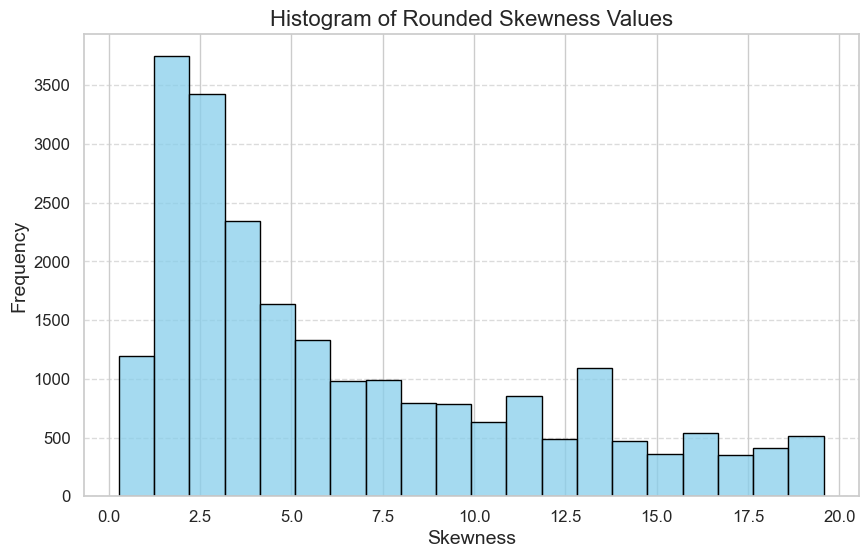

In [79]:
# Calculate skewness for each column in your DataFrame
skewness_valuesT = mergedT.skew()

# Round the skewness values
rounded_skewnessT_values = np.round(skewness_valuesT, decimals=2)

# Set seaborn style
sns.set(style="whitegrid")

# Plot a histogram of rounded skewness values
plt.figure(figsize=(10, 6))
sns.histplot(rounded_skewnessT_values, bins=20, color='skyblue', edgecolor='black')
plt.title('Histogram of Rounded Skewness Values', fontsize=16)
plt.xlabel('Skewness', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [80]:
# Calculate kurtosis for each column in your DataFrame
kurtosis_valuesT = mergedT[random_columns].kurtosis()

# Print kurtosis values
print("Kurtosis for each feature:")
print(kurtosis_valuesT)

Kurtosis for each feature:
RRAS       8.153772
CHTF18    36.056907
SMIM30    18.531288
dtype: float64


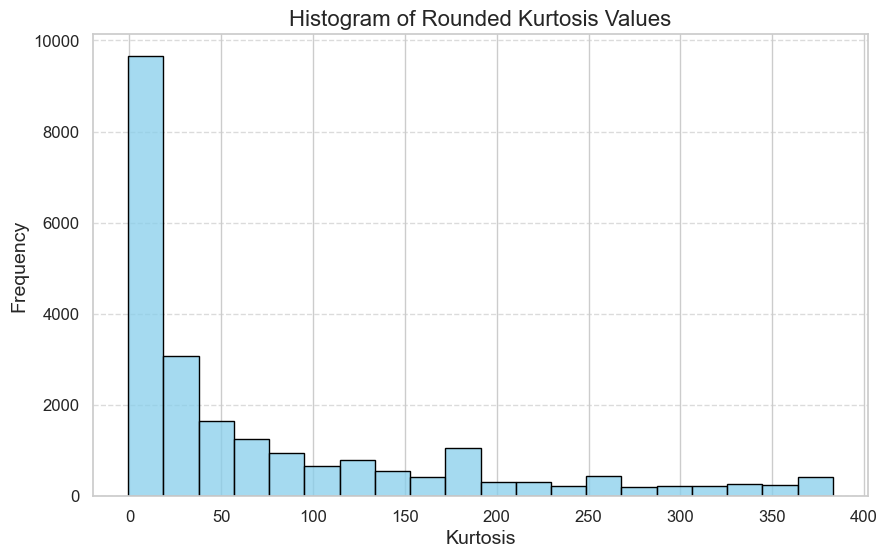

In [81]:
# Calculate kurtosis for each column in your DataFrame
kurtosis_valuesT = mergedT.kurtosis()

# Round the kurtosis values
rounded_kurtosisT_values = np.round(kurtosis_valuesT, decimals=2)

# Set seaborn style
sns.set(style="whitegrid")

# Plot a histogram of rounded kurtosis values
plt.figure(figsize=(10, 6))
sns.histplot(rounded_kurtosisT_values, bins=20, color='skyblue', edgecolor='black')
plt.title('Histogram of Rounded Kurtosis Values', fontsize=16)
plt.xlabel('Kurtosis', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [62]:
# Test normality using the Kolmogorov-Smirnov test impl. before
non_normal_countT = test_distribution_per_feature(mergedT)

All features have non-normal distribution


In [ ]:
# Now test other distribition in the same way
test_poissondistribution_per_feature(mergedT)

/Users/filipporonzino/anaconda3/lib/python3.11/site-packages/scipy/stats/_stats_py.py:7985: RuntimeWarning: divide by zero encountered in divide
  terms = (f_obs_float - f_exp)**2 / f_exp
/Users/filipporonzino/anaconda3/lib/python3.11/site-packages/scipy/stats/_stats_py.py:7985: RuntimeWarning: overflow encountered in divide
  terms = (f_obs_float - f_exp)**2 / f_exp
/Users/filipporonzino/.local/lib/python3.11/site-packages/numpy/core/_methods.py:49: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)


Some features might have poisson distribution
Number of features that might have poisson distribution: 5


['output.STAR.1_G12_Hypo_S318_Aligned.sortedByCoord.out.bam',
 'output.STAR.1_H1_Norm_S337_Aligned.sortedByCoord.out.bam',
 'output.STAR.1_H5_Norm_S341_Aligned.sortedByCoord.out.bam',
 'output.STAR.2_D8_Hypo_S176_Aligned.sortedByCoord.out.bam',
 'output.STAR.3_E7_Hypo_S229_Aligned.sortedByCoord.out.bam']

In [ ]:
test_negative_binomial_distribution_per_feature(mergedT)

Some features might have Negative Binomial distribution
Number of features with Negative Binomial distribution: 5


['output.STAR.1_D8_Hypo_S170_Aligned.sortedByCoord.out.bam',
 'output.STAR.1_E1_Norm_S193_Aligned.sortedByCoord.out.bam',
 'output.STAR.1_F10_Hypo_S268_Aligned.sortedByCoord.out.bam',
 'output.STAR.2_D8_Hypo_S176_Aligned.sortedByCoord.out.bam',
 'output.STAR.3_E7_Hypo_S229_Aligned.sortedByCoord.out.bam']

________________________________________________________________________________________________________________________

## Transformations 

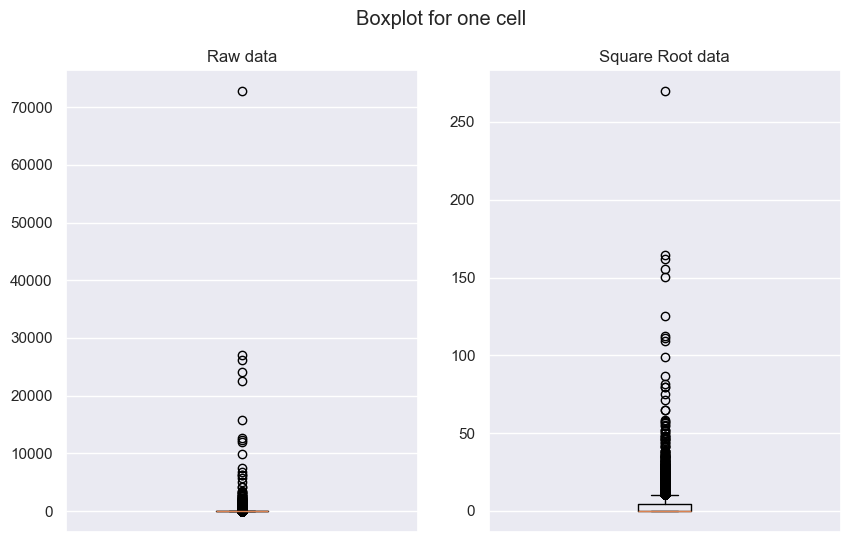

In [17]:
# Highly non normal distribution hence we take concave transformations the features
# Inspect first a single randomly selected feature

# we are using the transposed dataset

# Select a random index with seed
np.random.seed(43)
randomindex = np.random.randint(0, mergedT.shape[1])

# Apply the square root of the feature with random index
mergedT_squareroot = np.sqrt(mergedT[mergedT.columns[randomindex]])
# Boxplot of the feature and the transformed feature
fig, axs = plt.subplots(1, 2, figsize=(10,6))
plt.suptitle("Boxplot for one cell")
axs[0].boxplot(mergedT[mergedT.columns[randomindex]]+1)
axs[0].set_title("Raw data")
axs[0].get_xaxis().set_visible(False)
axs[0].grid(True)
axs[1].boxplot(mergedT_squareroot)
axs[1].set_title("Square Root data")
axs[1].get_xaxis().set_visible(False)
axs[1].grid(True)

plt.show()

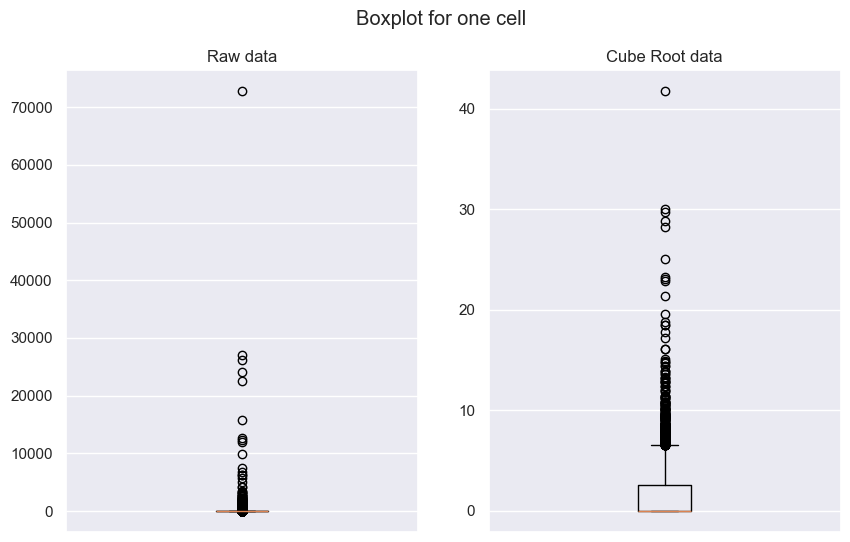

In [18]:
mergedT_cuberoot = np.cbrt(mergedT[mergedT.columns[randomindex]])
# Boxplot of the feature and the transformed feature
fig, axs = plt.subplots(1, 2, figsize=(10,6))
plt.suptitle("Boxplot for one cell")
axs[0].boxplot(mergedT[mergedT.columns[randomindex]]+1)
axs[0].set_title("Raw data")
axs[0].get_xaxis().set_visible(False)
axs[0].grid(True)
axs[1].boxplot(mergedT_cuberoot)
axs[1].set_title("Cube Root data")
axs[1].get_xaxis().set_visible(False)
axs[1].grid(True)

plt.show()

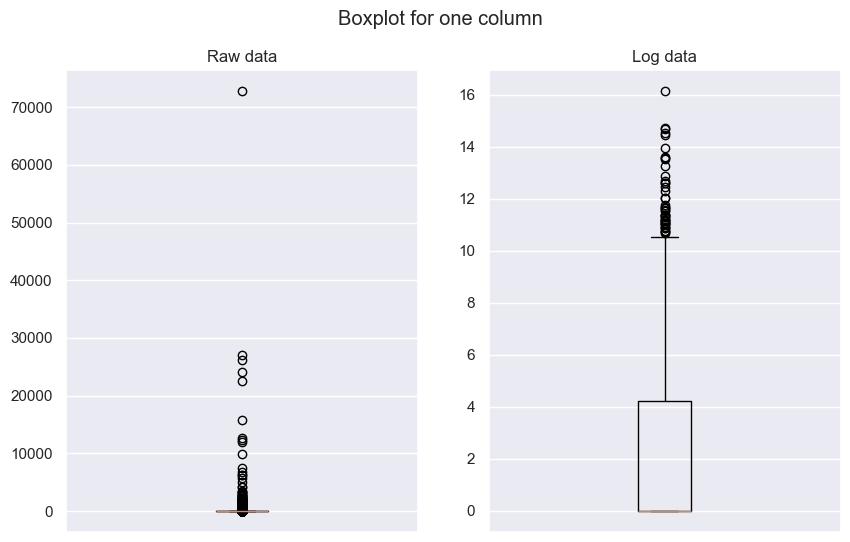

In [19]:
mergedT_log2_onecol = np.log2(mergedT[mergedT.columns[randomindex]]+1)
# Boxplot of the feature and the transformed feature
fig, axs = plt.subplots(1, 2, figsize=(10,6))
plt.suptitle("Boxplot for one column")
axs[0].boxplot(mergedT[mergedT.columns[randomindex]]+1)
axs[0].set_title("Raw data")
axs[0].get_xaxis().set_visible(False)
axs[0].grid(True)
axs[1].boxplot(mergedT_log2_onecol)
axs[1].set_title("Log data")
axs[1].get_xaxis().set_visible(False)
axs[1].grid(True)

plt.show()

Also in this case log transformation is the best one.

Skewness of raw data: 79.49713904620998
Skewness of log transformed data: 0.9922464387378741
Skewness of square root transformed data: 11.603531765135623
Skewness of cube root transformed data: 2.5410446411025633


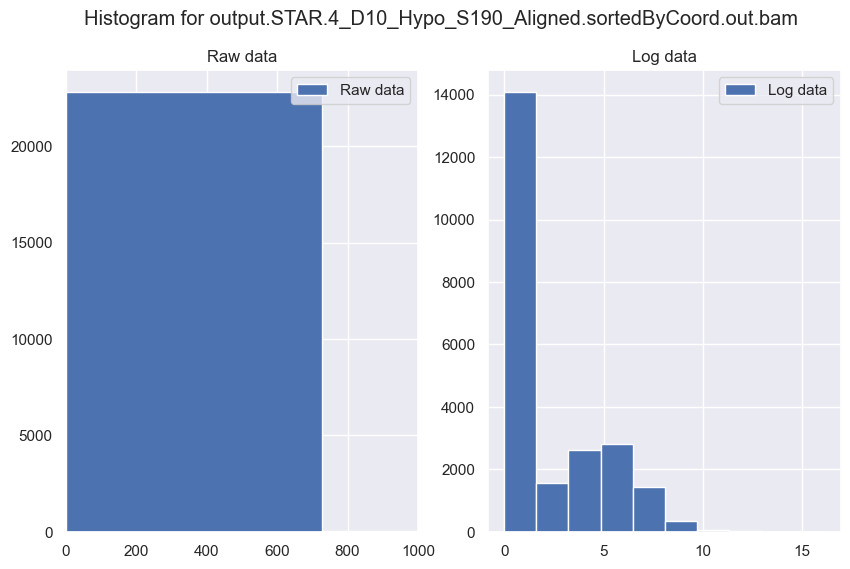

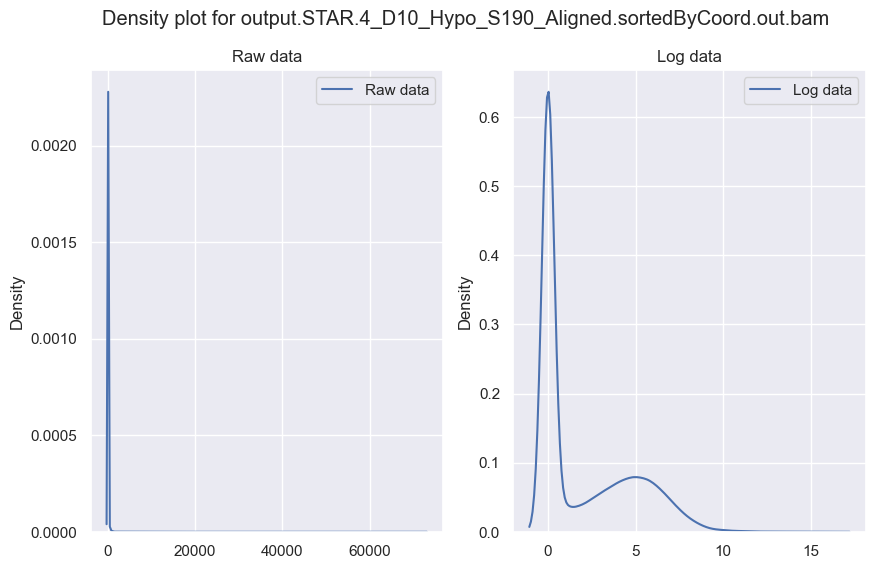

In [21]:
# Prove that log transformation is the best
# Calculate the skewness of the raw data
skewness_raw = mergedT[mergedT.columns[randomindex]].skew()
# Calculate the skewness of the log transformed data
skewness_log = np.log2(mergedT[mergedT.columns[randomindex]]+1).skew()
# Calculate the skewness of the square root transformed data
skewness_sqrt = np.sqrt(mergedT[mergedT.columns[randomindex]]).skew()
# Calculate the skewness of the cube root transformed data
skewness_cbrt = np.cbrt(mergedT[mergedT.columns[randomindex]]).skew()
# Print the skewness values
print(f"Skewness of raw data: {skewness_raw}")
print(f"Skewness of log transformed data: {skewness_log}")
print(f"Skewness of square root transformed data: {skewness_sqrt}")
print(f"Skewness of cube root transformed data: {skewness_cbrt}")

# Plot the histogram of transformed column, inspect why the skewness is negative
fig, axs = plt.subplots(1, 2, figsize=(10,6))
plt.suptitle(f"Histogram for {mergedT.columns[randomindex]}")
axs[0].hist(mergedT[mergedT.columns[randomindex]], bins = 100, label="Raw data")
# Set x-axis limit
axs[0].set_xlim(0, 1000)
axs[0].set_title("Raw data")
axs[0].grid(True)
axs[0].legend()  # Adding legend here
axs[1].hist(mergedT_log2_onecol, label="Log data")
axs[1].set_title("Log data")
axs[1].grid(True)
axs[1].legend()  # Adding legend here

# Plot the density of the transformed column
fig, axs = plt.subplots(1, 2, figsize=(10,6))
plt.suptitle(f"Density plot for {mergedT.columns[randomindex]}")
sns.kdeplot(mergedT[mergedT.columns[randomindex]], ax=axs[0], label="Raw data")
axs[0].set_title("Raw data")
axs[0].grid(True)
axs[0].legend()  # Adding legend here
axs[0].set_xlabel('')
sns.kdeplot(mergedT_log2_onecol, ax=axs[1], label="Log data")
axs[1].set_title("Log data")
axs[1].grid(True)
axs[1].legend()
axs[1].set_xlabel('')

plt.show()

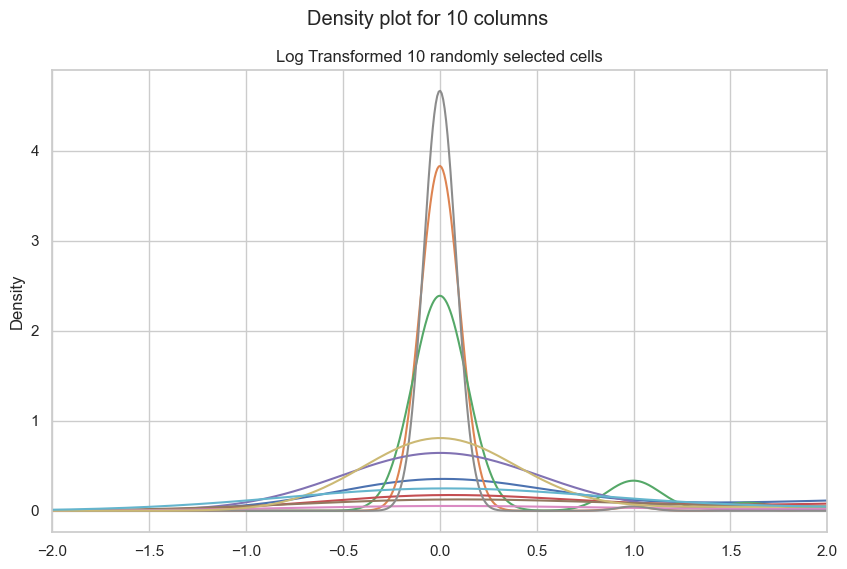

In [104]:
# Plot the densities of 10 randomly selected features all in one plot with sns with rescaled x axis
np.random.seed(43)
fig, ax = plt.subplots(1, 1, figsize=(10,6))
plt.suptitle("Density plot for 10 columns")
for i in np.random.randint(0, mergedT.shape[1], 10):
    np.log2(mergedT[mergedT.columns[i]]+1).plot.density(legend = False)
ax.set_title("Log Transformed 10 randomly selected cells")
# Rescale x limits
ax.set_xlim(-2.0, 2.0)
plt.grid(True)
ax.grid(True)
plt.show()

Bimodal distribution is still present.

Skewness of log transformed data: 3.614758672946791
Skewness of cube root transformed data: 3.5275395722809226
Skewness of square root transformed data: 4.225461833777775


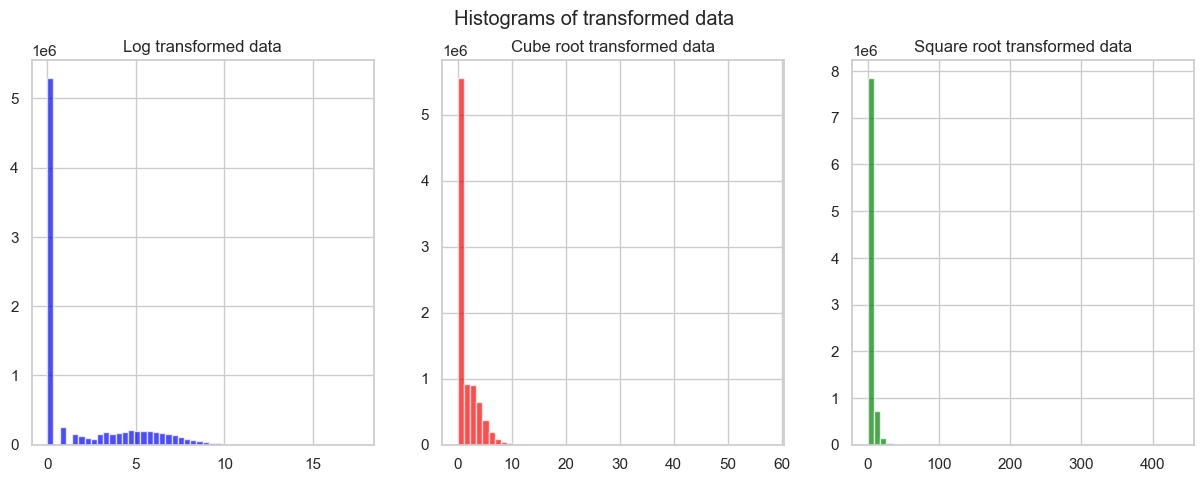

In [105]:
# Apply the log transformation to the entire dataset
mergedT_log = np.log2(mergedT+1)
mergedT_cbrt = np.cbrt(mergedT)
mergedT_sqrt = np.sqrt(mergedT)
# Convert to DataFrame
mergedT_log = pd.DataFrame(mergedT_log, columns=mergedT.columns, index=mergedT.index)
mergedT_cbrt = pd.DataFrame(mergedT_cbrt, columns=mergedT.columns, index=mergedT.index)
mergedT_sqrt = pd.DataFrame(mergedT_sqrt, columns=mergedT.columns, index=mergedT.index)
# Check skewness of the transformed data
skewness_log = mergedT_log.skew()
skewness_cbrt = mergedT_cbrt.skew()
skewness_sqrt = mergedT_sqrt.skew()
# Print the skewness values
print(f"Skewness of log transformed data: {skewness_log.mean()}")
print(f"Skewness of cube root transformed data: {skewness_cbrt.mean()}")
print(f"Skewness of square root transformed data: {skewness_sqrt.mean()}")
# Plot the histograms of the transformed data
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
plt.suptitle("Histograms of transformed data")
axs[0].hist(mergedT_log.values.flatten(), bins=50, color='blue', alpha=0.7)
axs[0].set_title("Log transformed data")
axs[1].hist(mergedT_cbrt.values.flatten(), bins=50, color='red', alpha=0.7)
axs[1].set_title("Cube root transformed data")
axs[2].hist(mergedT_sqrt.values.flatten(), bins=50, color='green', alpha=0.7)
axs[2].set_title("Square root transformed data")
plt.show()

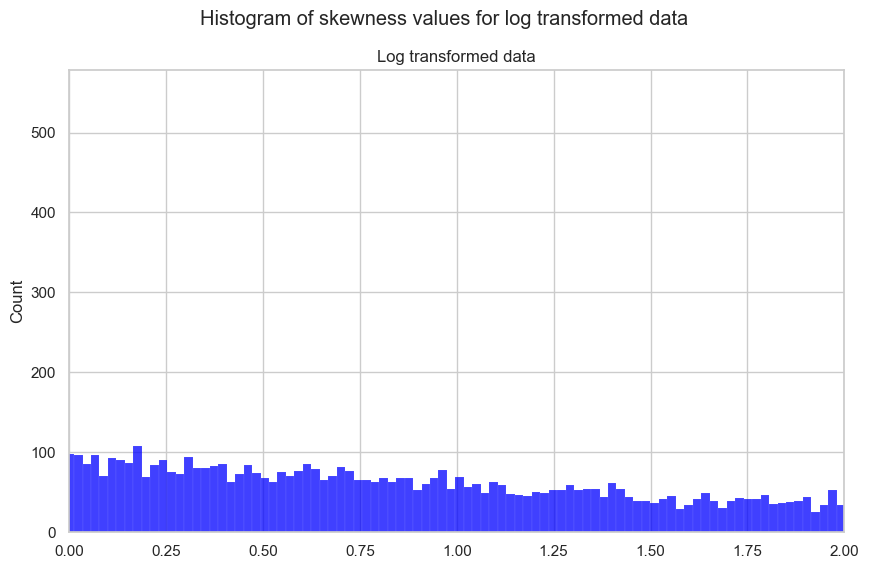

In [106]:
# Create a list of skewness values for all columns
skewness_log = mergedT_log.skew()

# Now we histogram plot the skewness values for the log transformed data
fig, ax = plt.subplots(1, 1, figsize=(10,6))
plt.suptitle("Histogram of skewness values for log transformed data")
sns.histplot(skewness_log, bins=1000, color='blue')
ax.set_title("Log transformed data")
# Set x limits
ax.set_xlim(0, 2)
plt.grid(True)
plt.show()

## Normalization 

We use CPM (Counts Per Million) normalization, which is a common normalization technique for RNA-seq data. It is calculated as follows:
CPM values are calculated by dividing the number of reads mapped to a gene by a million scaling factor divided by the total of mapped reads.

We will do it across columns (i.e. across cells) because we want the genes' reads to be "normalized" and so comparable across different observations.

In [110]:
mergedT_cpm = pd.DataFrame()
for column in mergedT.columns:
    # Calculate the CPM
    cpm = mergedT[column] / mergedT[column].sum() * 1e6
    # Add the CPM to the new DataFrame
    mergedT_cpm = pd.concat([mergedT_cpm, cpm], axis=1)


In [111]:
mergedT_cpm.shape

(22934, 383)

In [112]:
mergedT_cpm.head()

output.STAR.1_A10_Hypo_S28_Aligned.sortedByCoord.out.bam  \
WASH7P                                              0.000000          
MIR6859-1                                           0.000000          
WASH9P                                              1.068248          
OR4F29                                              0.000000          
MTND1P23                                            0.000000          

           output.STAR.1_A11_Hypo_S29_Aligned.sortedByCoord.out.bam  \
WASH7P                                                   0.0          
MIR6859-1                                                0.0          
WASH9P                                                   0.0          
OR4F29                                                   0.0          
MTND1P23                                                 0.0          

           output.STAR.1_A12_Hypo_S30_Aligned.sortedByCoord.out.bam  \
WASH7P                                                   0.0          
MIR6859-1                                                0.0          
WASH9P                                                   0.0          
OR4F29                                                   0.0          
MTND1P23                                                 0.0          

           output.STAR.1_A1_Norm_S1_Aligned.sortedByCoord.out.bam  \
WASH7P                                                   0.0        
MIR6859-1                                                0.0        
WASH9P                                                   0.0        
OR4F29                                                   0.0        
MTND1P23                                                 0.0        

           output.STAR.1_A2_Norm_S2_Aligned.sortedByCoord.out.bam  \
WASH7P                                                   0.0        
MIR6859-1                                                0.0        
WASH9P                                                   0.0        
OR4F29                                                   0.0        
MTND1P23                                                 0.0        

           output.STAR.1_A3_Norm_S3_Aligned.sortedByCoord.out.bam  \
WASH7P                                              0.000000        
MIR6859-1                                           0.000000        
WASH9P                                              0.775673        
OR4F29                                              0.000000        
MTND1P23                                            0.000000        

           output.STAR.1_A4_Norm_S4_Aligned.sortedByCoord.out.bam  \
WASH7P                                              0.000000        
MIR6859-1                                           0.000000        
WASH9P                                              5.783158        
OR4F29                                              0.000000        
MTND1P23                                            0.000000        

           output.STAR.1_A5_Norm_S5_Aligned.sortedByCoord.out.bam  \
WASH7P                                              0.000000        
MIR6859-1                                           0.000000        
WASH9P                                              0.694678        
OR4F29                                              0.000000        
MTND1P23                                            0.000000        

           output.STAR.1_A6_Norm_S6_Aligned.sortedByCoord.out.bam  \
WASH7P                                                   0.0        
MIR6859-1                                                0.0        
WASH9P                                                   0.0        
OR4F29                                                   0.0        
MTND1P23                                                 0.0        

           output.STAR.1_A7_Hypo_S25_Aligned.sortedByCoord.out.bam  ...  \
WASH7P                                                   0.0        ...   
MIR6859-1                                                0.0        ...   
WASH9P         

In [113]:
mergedT_cpm.describe()

output.STAR.1_A10_Hypo_S28_Aligned.sortedByCoord.out.bam  \
count                                       22934.000000          
mean                                           43.603384          
std                                           497.493825          
min                                             0.000000          
25%                                             0.000000          
50%                                             0.000000          
75%                                            18.160220          
max                                         49934.195908          

       output.STAR.1_A11_Hypo_S29_Aligned.sortedByCoord.out.bam  \
count                                       22934.000000          
mean                                           43.603384          
std                                           739.236938          
min                                             0.000000          
25%                                             0.000000          
50%                                             0.000000          
75%                                             0.000000          
max                                         49822.064057          

       output.STAR.1_A12_Hypo_S30_Aligned.sortedByCoord.out.bam  \
count                                       22934.000000          
mean                                           43.603384          
std                                           522.869294          
min                                             0.000000          
25%                                             0.000000          
50%                                             0.000000          
75%                                             2.522106          
max                                         41386.250486          

       output.STAR.1_A1_Norm_S1_Aligned.sortedByCoord.out.bam  \
count                                       22934.000000        
mean                                           43.603384        
std                                           259.473263        
min                                             0.000000        
25%                                             0.000000        
50%                                             0.000000        
75%                                             0.000000        
max                                         12298.395676        

       output.STAR.1_A2_Norm_S2_Aligned.sortedByCoord.out.bam  \
count                                       22934.000000        
mean                                           43.603384        
std                                           371.481087        
min                                             0.000000        
25%                                             0.000000        
50%                                             0.000000        
75%                                            21.004495        
max                                         31752.795098        

       output.STAR.1_A3_Norm_S3_Aligned.sortedByCoord.out.bam  \
count                                       22934.000000        
mean                                           43.603384        
std                                           390.628275        
min                                             0.000000        
25%                                             0.000000        
50%                                             0.000000        
75%                                            17.840480        
max                                         36344.935592        

       output.STAR.1_A4_Norm_S4_Aligned.sortedByCoord.out.bam  \
count                                       22934.000000        
mean                                           43.603384        
std                                           248.948488        
min                                             0.000000        
25%                                             0.000000        
50%                                            

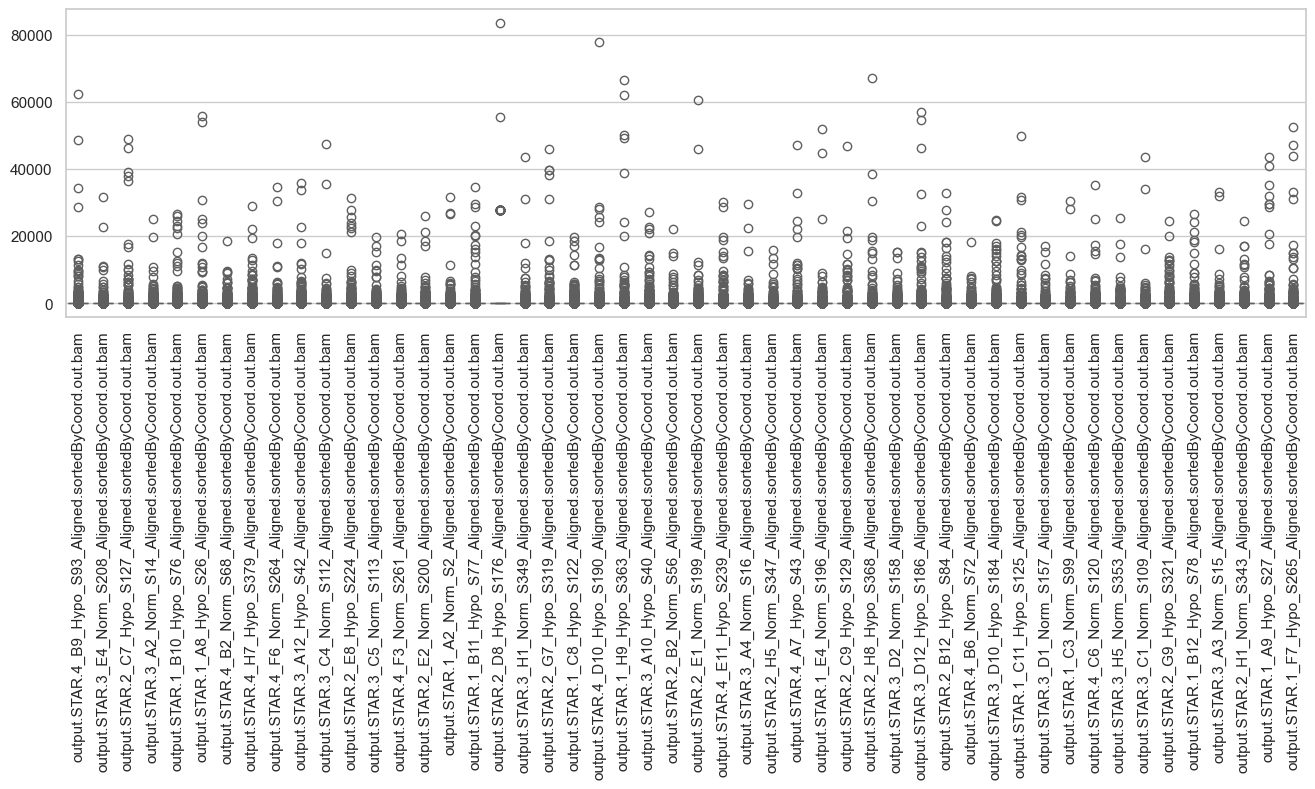

In [114]:
#box-plot of log-transformed 50 random columns of dataframe
random_columns = list(range(0, mergedT.shape[1])) # list of integers from 1 to 243
random.shuffle(random_columns)
random_columns = random_columns[:50]
normalized_small = mergedT_cpm.iloc[:, random_columns]
plt.figure(figsize=(16,4))
plot=sns.boxplot(data=normalized_small,palette="Set3")
plt.setp(plot.get_xticklabels(), rotation=90);

Mean Skewness of CPM normalized data: 55.60321714622331
Mean Kurtosis of CPM normalized data: 4165.763054333273


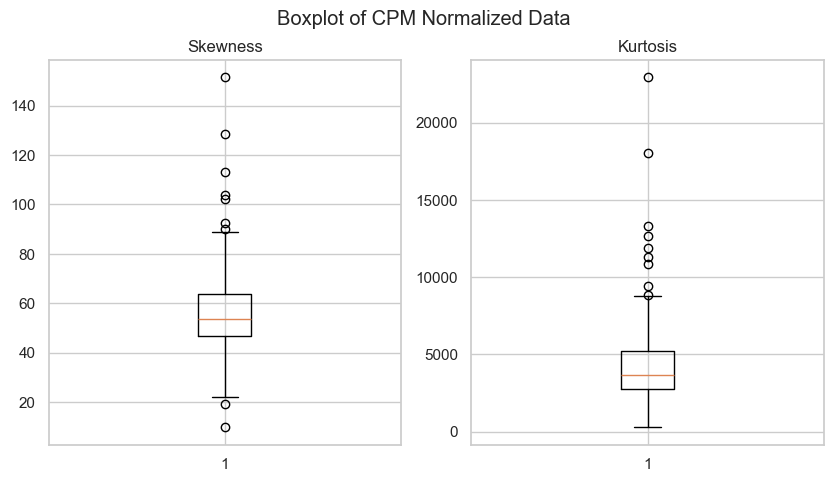

In [115]:
# Check again skewness and kurtosis of the CPM normalized data
skewness_cpm = mergedT_cpm.skew()
kurtosis_cpm = mergedT_cpm.kurtosis()
# Print the skewness and kurtosis values
print(f"Mean Skewness of CPM normalized data: {skewness_cpm.mean()}")
print(f"Mean Kurtosis of CPM normalized data: {kurtosis_cpm.mean()}")
# boxplot of skewness
fig, ax = plt.subplots(1, 2, figsize=(10,5))
plt.suptitle("Boxplot of CPM Normalized Data")
ax[0].boxplot(skewness_cpm)
ax[0].grid(True)
ax[0].set_title("Skewness")
ax[1].boxplot(kurtosis_cpm)
ax[1].grid(True)
ax[1].set_title("Kurtosis")
plt.show()


In [116]:
# Now we will apply the log transformation to the CPM normalized data
mergedT_cpm_log = np.log2(mergedT_cpm+1)
# Convert to DataFrame
mergedT_cpm_log = pd.DataFrame(mergedT_cpm_log, columns=mergedT_cpm.columns, index=mergedT_cpm.index)

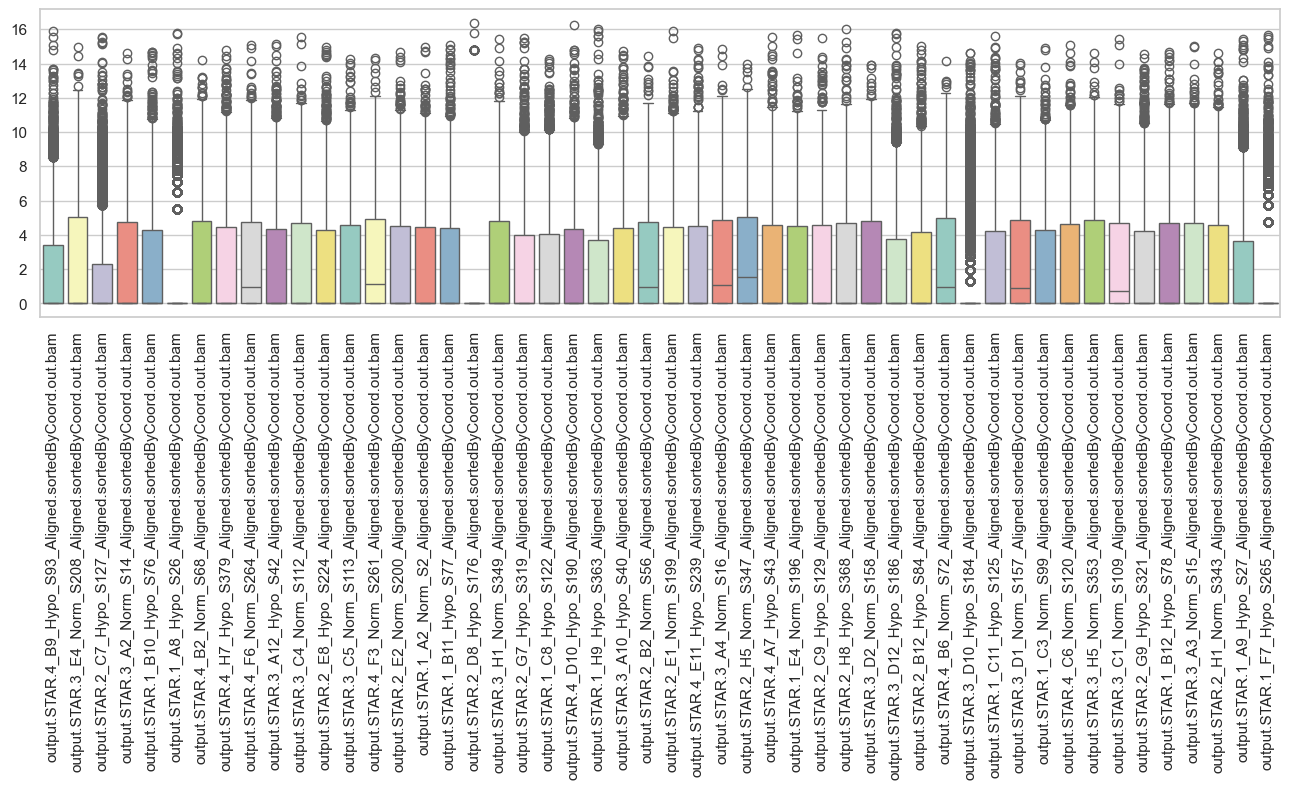

In [117]:
# Study the distributions of 10 random columns now (boxplot and densities)
log_small = mergedT_cpm_log.iloc[:, random_columns]
plt.figure(figsize=(16,4))
plot=sns.boxplot(data=log_small, palette="Set3")
plt.setp(plot.get_xticklabels(), rotation=90);

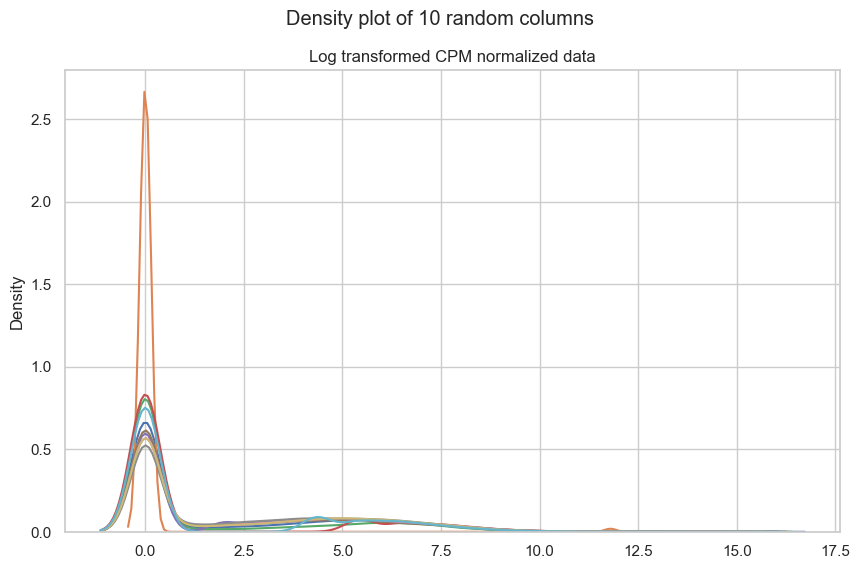

In [118]:
# Densities of the 10 random columns
fig, ax = plt.subplots(1, 1, figsize=(10,6))
plt.suptitle("Density plot of 10 random columns")
for i in range(10):
    sns.kdeplot(mergedT_cpm_log.iloc[:, i], ax=ax)
ax.set_title("Log transformed CPM normalized data")
ax.set_xlabel("")
ax.grid(True)
plt.show()

___________________________________________________________________________________________________________________

## Filtering  

We do filtering in the same way as we did for the other dataset

In [119]:
def filter_CPM(data, threshold):
    data_filtered = pd.DataFrame()
    # Keep track of the number of rows removed
    removed_genes = 0
    # Create a mask to filter out rows with low counts
    if 'Target' in data.index:
        data = data.drop('Target')
    mask_thr = data > threshold
    mask_rows = mask_thr.sum(axis=1) >= 2
    data_filtered = data.loc[mask_rows, :]
    return data_filtered

In [120]:
filteredcpm = filter_CPM(mergedT_cpm_log, 0.5)
print(filteredcpm)
print("Number of rows before filtering:", mergedT_cpm_log.shape[0])
print("Number of rows after filtering:", filteredcpm.shape[0])
print("Number of rows removed:", mergedT_cpm_log.shape[0] - filteredcpm.shape[0])

           output.STAR.1_A10_Hypo_S28_Aligned.sortedByCoord.out.bam  \
WASH7P                                              0.000000          
MIR6859-1                                           0.000000          
WASH9P                                              1.048409          
OR4F29                                              0.000000          
MTND1P23                                            0.000000          
...                                                      ...          
MT-TE                                               2.398622          
MT-CYB                                              8.177056          
MT-TT                                               0.000000          
MT-TP                                               2.664765          
MAFIP                                               3.254894          

           output.STAR.1_A11_Hypo_S29_Aligned.sortedByCoord.out.bam  \
WASH7P                                              0.000000          
MIR68

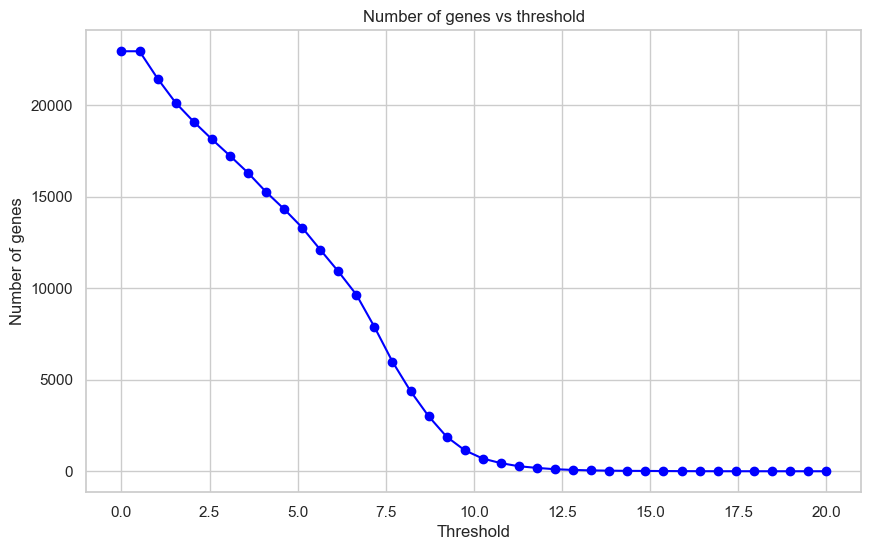

In [121]:
# Grid search on filter_CPM for the best threshold
thresholds = np.linspace(start = 0, stop = 20, num = 40)
n_rows = [] # rows are genes
for threshold in thresholds:
    filtered = filter_CPM(mergedT_cpm_log, threshold)
    n_rows.append(filtered.shape[0])
# Plot the number of rows vs the threshold
plt.figure(figsize=(10, 6))
plt.plot(thresholds, n_rows, marker='o', color='blue')
plt.title("Number of genes vs threshold")
plt.xlabel("Threshold")
plt.ylabel("Number of genes")
plt.grid(True)
plt.show()

In [122]:
#we compute the percentege of genes that are removed for 1.5 threshold
filtered = filter_CPM(mergedT_cpm_log, 1.5)
percentage = (mergedT_cpm_log.shape[0] - filtered.shape[0]) / mergedT_cpm_log.shape[0] * 100
print(f"Percentage of genes removed for threshold 1.5: {percentage:.2f}%")
print(f"Number of remaining genes: {filtered.shape[0]}")

Percentage of genes removed for threshold 1.5: 11.79%
Number of remaining genes: 20231


We use the same threshold for the filtering, obtaining a removal percentage of 11.79, still in the range 10-20% as in the previous dataset.

/Users/filipporonzino/anaconda3/lib/python3.11/site-packages/scanpy/preprocessing/_highly_variable_genes.py:72: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  warnings.warn(


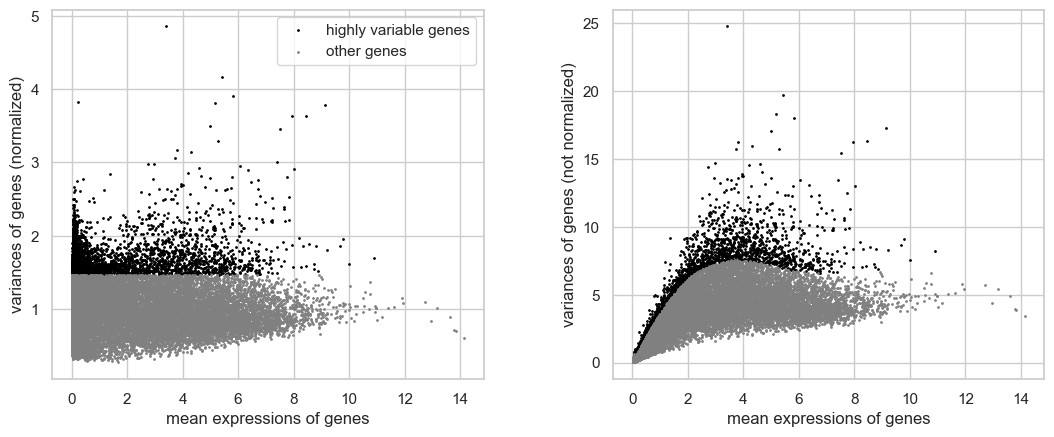

In [123]:
# Now scatter plot the variance of the genes
filt_first = filter_CPM(mergedT_cpm_log, 1.5).T
adata = sc.AnnData(filt_first)

sc.pp.highly_variable_genes(adata, n_top_genes=3000, flavor='seurat_v3')
# Note since our dataset is already log-transformed as the function 'Expects logarithmized data'
sc.pl.highly_variable_genes(adata)

In [124]:
adata = adata[:, adata.var['highly_variable']]
print("Total matching: ", adata.var['highly_variable'].index.isin(df_seq_MFiltNorm.index).astype(bool).sum())
print("Percentage matching to the given training dataset: ", round(adata.var['highly_variable'].index.isin(df_seq_MFiltNorm.index).astype(bool).sum()/3000*100, 2), "%")

Total matching:  2039
Percentage matching to the given training dataset:  67.97 %


We see again that the overlap between the two datasets is very high, which likely means that our analysis was in the right direction. 

____________________________________________________________________________________________________________________
____________________________________________________________________________________________________________________

## Dimensionality Reduction for Visualization


We now perform PCA in the same flavour.

In [15]:
df_seq_MFiltNorm.T.head()

CYP1B1  CYP1B1-AS1  \
output.STAR.2_B3_Norm_S57_Aligned.sortedByCoord...     343         140   
output.STAR.2_B4_Norm_S58_Aligned.sortedByCoord...     131          59   
output.STAR.2_B5_Norm_S59_Aligned.sortedByCoord...     452         203   
output.STAR.2_B6_Norm_S60_Aligned.sortedByCoord...      27           7   
output.STAR.2_B7_Hypo_S79_Aligned.sortedByCoord...    5817        2669   

                                                    CYP1A1  NDRG1  DDIT4  \
output.STAR.2_B3_Norm_S57_Aligned.sortedByCoord...       0      0    386   
output.STAR.2_B4_Norm_S58_Aligned.sortedByCoord...       0      1    289   
output.STAR.2_B5_Norm_S59_Aligned.sortedByCoord...       0      0      0   
output.STAR.2_B6_Norm_S60_Aligned.sortedByCoord...       0      0    288   
output.STAR.2_B7_Hypo_S79_Aligned.sortedByCoord...       0    654   2484   

                                                    PFKFB3  HK2  AREG  MYBL2  \
output.STAR.2_B3_Norm_S57_Aligned.sortedByCoord...      75    0     0    476   
output.STAR.2_B4_Norm_S58_Aligned.sortedByCoord...      42    0   856   1586   
output.STAR.2_B5_Norm_S59_Aligned.sortedByCoord...       0    0     0    775   
output.STAR.2_B6_Norm_S60_Aligned.sortedByCoord...     214   15   242   1191   
output.STAR.2_B7_Hypo_S79_Aligned.sortedByCoord...    1603  748   436      0   

                                                    ADM  ...  CD27-AS1  DNAI7  \
output.STAR.2_B3_Norm_S57_Aligned.sortedByCoord...    0  ...        63      0   
output.STAR.2_B4_Norm_S58_Aligned.sortedByCoord...    0  ...         0      0   
output.STAR.2_B5_Norm_S59_Aligned.sortedByCoord...    0  ...        15      0   
output.STAR.2_B6_Norm_S60_Aligned.sortedByCoord...    0  ...         1      0   
output.STAR.2_B7_Hypo_S79_Aligned.sortedByCoord...    0  ...         0      0   

                                                    MAFG  LZTR1  BCO2  GRIK5  \
output.STAR.2_B3_Norm_S57_Aligned.sortedByCoord...    17     59     0      0   
output.STAR.2_B4_Norm_S58_Aligned.sortedByCoord...     1     25     0      0   
output.STAR.2_B5_Norm_S59_Aligned.sortedByCoord...    23      0     0      0   
output.STAR.2_B6_Norm_S60_Aligned.sortedByCoord...     3     10     0      0   
output.STAR.2_B7_Hypo_S79_Aligned.sortedByCoord...    63      0     0      0   

                                                    SLC25A27  DENND5A  CDK5R1  \
output.STAR.2_B3_Norm_S57_Aligned.sortedByCoord...         0       51       0   
output.STAR.2_B4_Norm_S58_Aligned.sortedByCoord...         0       34       0   
output.STAR.2_B5_Norm_S59_Aligned.sortedByCoord...         0        0       0   
output.STAR.2_B6_Norm_S60_Aligned.sortedByCoord...         0        4       0   
output.STAR.2_B7_Hypo_S79_Aligned.sortedByCoord...         0       60       0   

                                                    FAM13A-AS1  
output.STAR.2_B3_Norm_S57_Aligned.sortedByCoord...           0  
output.STAR.2_B4_Norm_S58_Aligned.sortedByCoord...           0  
output.STAR.2_B5_Norm_S59_Aligned.sortedByCoord...           0  
output.STAR.2_B6_Norm_S60_Aligned.sortedByCoord...           0  
output.STAR.2_B7_Hypo_S79_Aligned.sortedByCoord...           0  

[5 rows x 3000 columns]

In [16]:
df_dim_red = pd.DataFrame(StandardScaler().fit_transform(df_seq_MFiltNorm.T), columns=df_seq_MFiltNorm.T.columns, index=df_seq_MFiltNorm.T.index)
df_dim_red.T.head()

output.STAR.2_B3_Norm_S57_Aligned.sortedByCoord.out.bam  \
CYP1B1                                              -0.618399         
CYP1B1-AS1                                          -0.614660         
CYP1A1                                              -0.284194         
NDRG1                                               -0.792463         
DDIT4                                               -0.615162         

            output.STAR.2_B4_Norm_S58_Aligned.sortedByCoord.out.bam  \
CYP1B1                                              -0.644047         
CYP1B1-AS1                                          -0.638161         
CYP1A1                                              -0.284194         
NDRG1                                               -0.791156         
DDIT4                                               -0.643563         

            output.STAR.2_B5_Norm_S59_Aligned.sortedByCoord.out.bam  \
CYP1B1                                              -0.605212         
CYP1B1-AS1                                          -0.596382         
CYP1A1                                              -0.284194         
NDRG1                                               -0.792463         
DDIT4                                               -0.728181         

            output.STAR.2_B6_Norm_S60_Aligned.sortedByCoord.out.bam  \
CYP1B1                                              -0.656629         
CYP1B1-AS1                                          -0.653247         
CYP1A1                                              -0.284194         
NDRG1                                               -0.792463         
DDIT4                                               -0.643856         

            output.STAR.2_B7_Hypo_S79_Aligned.sortedByCoord.out.bam  \
CYP1B1                                               0.043851         
CYP1B1-AS1                                           0.119077         
CYP1A1                                              -0.284194         
NDRG1                                                0.062233         
DDIT4                                               -0.000878         

            output.STAR.2_B9_Hypo_S81_Aligned.sortedByCoord.out.bam  \
CYP1B1                                              -0.195207         
CYP1B1-AS1                                          -0.201226         
CYP1A1                                              -0.270202         
NDRG1                                                0.858121         
DDIT4                                                0.031915         

            output.STAR.2_C10_Hypo_S130_Aligned.sortedByCoord.out.bam  \
CYP1B1                                               0.460752           
CYP1B1-AS1                                           0.466362           
CYP1A1                                              -0.242041           
NDRG1                                                2.649847           
DDIT4                                               -0.340813           

            output.STAR.2_C11_Hypo_S131_Aligned.sortedByCoord.out.bam  \
CYP1B1                                               1.946399           
CYP1B1-AS1                                           1.988672           
CYP1A1                                              -0.205732           
NDRG1                                               -0.086750           
DDIT4                                               -0.129708           

            output.STAR.2_C1_Norm_S103_Aligned.sortedByCoord.out.bam  \
CYP1B1                                              -0.537342          
CYP1B1-AS1                                          -0.522109          
CYP1A1                                              -0.284194          
NDRG1                                               -0.792463          
DDIT4                                               -0.717640          

            output.STAR.2_C2_Norm_S104_Aligned.sortedByCoord.out.bam  ...  \
CYP1B1                                              -0.653484 

In [17]:
df_dim_red

CYP1B1  CYP1B1-AS1  \
output.STAR.2_B3_Norm_S57_Aligned.sortedByCoord... -0.618399   -0.614660   
output.STAR.2_B4_Norm_S58_Aligned.sortedByCoord... -0.644047   -0.638161   
output.STAR.2_B5_Norm_S59_Aligned.sortedByCoord... -0.605212   -0.596382   
output.STAR.2_B6_Norm_S60_Aligned.sortedByCoord... -0.656629   -0.653247   
output.STAR.2_B7_Hypo_S79_Aligned.sortedByCoord...  0.043851    0.119077   
...                                                      ...         ...   
output.STAR.4_H5_Norm_S359_Aligned.sortedByCoor... -0.636183   -0.625685   
output.STAR.4_H6_Norm_S360_Aligned.sortedByCoor... -0.598921   -0.586228   
output.STAR.4_H7_Hypo_S379_Aligned.sortedByCoor...  3.521815    3.324428   
output.STAR.4_H8_Hypo_S380_Aligned.sortedByCoor...  1.762629    1.617886   
output.STAR.4_H9_Hypo_S381_Aligned.sortedByCoor...  0.060305    0.031458   

                                                      CYP1A1     NDRG1  \
output.STAR.2_B3_Norm_S57_Aligned.sortedByCoord... -0.284194 -0.792463   
output.STAR.2_B4_Norm_S58_Aligned.sortedByCoord... -0.284194 -0.791156   
output.STAR.2_B5_Norm_S59_Aligned.sortedByCoord... -0.284194 -0.792463   
output.STAR.2_B6_Norm_S60_Aligned.sortedByCoord... -0.284194 -0.792463   
output.STAR.2_B7_Hypo_S79_Aligned.sortedByCoord... -0.284194  0.062233   
...                                                      ...       ...   
output.STAR.4_H5_Norm_S359_Aligned.sortedByCoor... -0.284017 -0.474892   
output.STAR.4_H6_Norm_S360_Aligned.sortedByCoor... -0.284194 -0.711437   
output.STAR.4_H7_Hypo_S379_Aligned.sortedByCoor...  1.712593  0.858121   
output.STAR.4_H8_Hypo_S380_Aligned.sortedByCoor... -0.184479  0.416397   
output.STAR.4_H9_Hypo_S381_Aligned.sortedByCoor... -0.191740  1.261945   

                                                       DDIT4    PFKFB3  \
output.STAR.2_B3_Norm_S57_Aligned.sortedByCoord... -0.615162 -0.674972   
output.STAR.2_B4_Norm_S58_Aligned.sortedByCoord... -0.643563 -0.690648   
output.STAR.2_B5_Norm_S59_Aligned.sortedByCoord... -0.728181 -0.710599   
output.STAR.2_B6_Norm_S60_Aligned.sortedByCoord... -0.643856 -0.608944   
output.STAR.2_B7_Hypo_S79_Aligned.sortedByCoord... -0.000878  0.050866   
...                                                      ...       ...   
output.STAR.4_H5_Norm_S359_Aligned.sortedByCoor... -0.650297 -0.578542   
output.STAR.4_H6_Norm_S360_Aligned.sortedByCoor... -0.606085 -0.267876   
output.STAR.4_H7_Hypo_S379_Aligned.sortedByCoor...  0.517954  1.979466   
output.STAR.4_H8_Hypo_S380_Aligned.sortedByCoor...  2.999975  0.328280   
output.STAR.4_H9_Hypo_S381_Aligned.sortedByCoor... -0.062072  0.842257   

                                                         HK2      AREG  \
output.STAR.2_B3_Norm_S57_Aligned.sortedByCoord... -0.473586 -0.522142   
output.STAR.2_B4_Norm_S58_Aligned.sortedByCoord... -0.473586  0.924384   
output.STAR.2_B5_Norm_S59_Aligned.sortedByCoord... -0.473586 -0.522142   
output.STAR.2_B6_Norm_S60_Aligned.sortedByCoord... -0.465405 -0.113194   
output.STAR.2_B7_Hypo_S79_Aligned.sortedByCoord... -0.065672  0.214640   
...                                                      ...       ...   
output.STAR.4_H5_Norm_S359_Aligned.sortedByCoor... -0.431049 -0.520452   
output.STAR.4_H6_Norm_S360_Aligned.sortedByCoor... -0.323617 -0.522142   
output.STAR.4_H7_Hypo_S379_Aligned.sortedByCoor... -0.091303 -0.522142   
output.STAR.4_H8_Hypo_S380_Aligned.sortedByCoor...  0.148646 -0.522142   
output.STAR.4_H9_Hypo_S381_Aligned.sortedByCoor...  0.751791 -0.236554   

                                                       MYBL2       ADM  ...  \
output.STAR.2_B3_Norm_S57_Aligned.sortedByCoord...  0.143860 -0.390037  ...   
output.STAR.2_B4_Norm_S58_Aligned.sortedByCoord...  2.114986 -0.390037  ...   
output.STAR.2_B5_Norm_S59_Aligned.sortedByCoord...  0.674821 -0.390037  ...   
output.STAR.2_B6_Norm_S60_Aligned.sortedByCoord...  1.413550 -0.390037  ...   
output.STAR.2_B7_Hypo_S79_Aligned.sortedByCoord... -0.701415 -0.390037  ...   


In [18]:
# Resetting the index with Filename
df_metaM.set_index('Filename', inplace=True)

In [19]:
merged_df_pca = pd.merge(df_dim_red, df_metaM['Condition'], left_index=True, right_index=True)
merged_df_pca

CYP1B1  CYP1B1-AS1  \
output.STAR.2_B3_Norm_S57_Aligned.sortedByCoord... -0.618399   -0.614660   
output.STAR.2_B4_Norm_S58_Aligned.sortedByCoord... -0.644047   -0.638161   
output.STAR.2_B5_Norm_S59_Aligned.sortedByCoord... -0.605212   -0.596382   
output.STAR.2_B6_Norm_S60_Aligned.sortedByCoord... -0.656629   -0.653247   
output.STAR.2_B7_Hypo_S79_Aligned.sortedByCoord...  0.043851    0.119077   
...                                                      ...         ...   
output.STAR.4_H5_Norm_S359_Aligned.sortedByCoor... -0.636183   -0.625685   
output.STAR.4_H6_Norm_S360_Aligned.sortedByCoor... -0.598921   -0.586228   
output.STAR.4_H7_Hypo_S379_Aligned.sortedByCoor...  3.521815    3.324428   
output.STAR.4_H8_Hypo_S380_Aligned.sortedByCoor...  1.762629    1.617886   
output.STAR.4_H9_Hypo_S381_Aligned.sortedByCoor...  0.060305    0.031458   

                                                      CYP1A1     NDRG1  \
output.STAR.2_B3_Norm_S57_Aligned.sortedByCoord... -0.284194 -0.792463   
output.STAR.2_B4_Norm_S58_Aligned.sortedByCoord... -0.284194 -0.791156   
output.STAR.2_B5_Norm_S59_Aligned.sortedByCoord... -0.284194 -0.792463   
output.STAR.2_B6_Norm_S60_Aligned.sortedByCoord... -0.284194 -0.792463   
output.STAR.2_B7_Hypo_S79_Aligned.sortedByCoord... -0.284194  0.062233   
...                                                      ...       ...   
output.STAR.4_H5_Norm_S359_Aligned.sortedByCoor... -0.284017 -0.474892   
output.STAR.4_H6_Norm_S360_Aligned.sortedByCoor... -0.284194 -0.711437   
output.STAR.4_H7_Hypo_S379_Aligned.sortedByCoor...  1.712593  0.858121   
output.STAR.4_H8_Hypo_S380_Aligned.sortedByCoor... -0.184479  0.416397   
output.STAR.4_H9_Hypo_S381_Aligned.sortedByCoor... -0.191740  1.261945   

                                                       DDIT4    PFKFB3  \
output.STAR.2_B3_Norm_S57_Aligned.sortedByCoord... -0.615162 -0.674972   
output.STAR.2_B4_Norm_S58_Aligned.sortedByCoord... -0.643563 -0.690648   
output.STAR.2_B5_Norm_S59_Aligned.sortedByCoord... -0.728181 -0.710599   
output.STAR.2_B6_Norm_S60_Aligned.sortedByCoord... -0.643856 -0.608944   
output.STAR.2_B7_Hypo_S79_Aligned.sortedByCoord... -0.000878  0.050866   
...                                                      ...       ...   
output.STAR.4_H5_Norm_S359_Aligned.sortedByCoor... -0.650297 -0.578542   
output.STAR.4_H6_Norm_S360_Aligned.sortedByCoor... -0.606085 -0.267876   
output.STAR.4_H7_Hypo_S379_Aligned.sortedByCoor...  0.517954  1.979466   
output.STAR.4_H8_Hypo_S380_Aligned.sortedByCoor...  2.999975  0.328280   
output.STAR.4_H9_Hypo_S381_Aligned.sortedByCoor... -0.062072  0.842257   

                                                         HK2      AREG  \
output.STAR.2_B3_Norm_S57_Aligned.sortedByCoord... -0.473586 -0.522142   
output.STAR.2_B4_Norm_S58_Aligned.sortedByCoord... -0.473586  0.924384   
output.STAR.2_B5_Norm_S59_Aligned.sortedByCoord... -0.473586 -0.522142   
output.STAR.2_B6_Norm_S60_Aligned.sortedByCoord... -0.465405 -0.113194   
output.STAR.2_B7_Hypo_S79_Aligned.sortedByCoord... -0.065672  0.214640   
...                                                      ...       ...   
output.STAR.4_H5_Norm_S359_Aligned.sortedByCoor... -0.431049 -0.520452   
output.STAR.4_H6_Norm_S360_Aligned.sortedByCoor... -0.323617 -0.522142   
output.STAR.4_H7_Hypo_S379_Aligned.sortedByCoor... -0.091303 -0.522142   
output.STAR.4_H8_Hypo_S380_Aligned.sortedByCoor...  0.148646 -0.522142   
output.STAR.4_H9_Hypo_S381_Aligned.sortedByCoor...  0.751791 -0.236554   

                                                       MYBL2       ADM  ...  \
output.STAR.2_B3_Norm_S57_Aligned.sortedByCoord...  0.143860 -0.390037  ...   
output.STAR.2_B4_Norm_S58_Aligned.sortedByCoord...  2.114986 -0.390037  ...   
output.STAR.2_B5_Norm_S59_Aligned.sortedByCoord...  0.674821 -0.390037  ...   
output.STAR.2_B6_Norm_S60_Aligned.sortedByCoord...  1.413550 -0.390037  ...   
output.STAR.2_B7_Hypo_S79_Aligned.sortedByCoord... -0.701415 -0.390037  ...   


The number of dimensions needed to explain 95% of the variance is 204


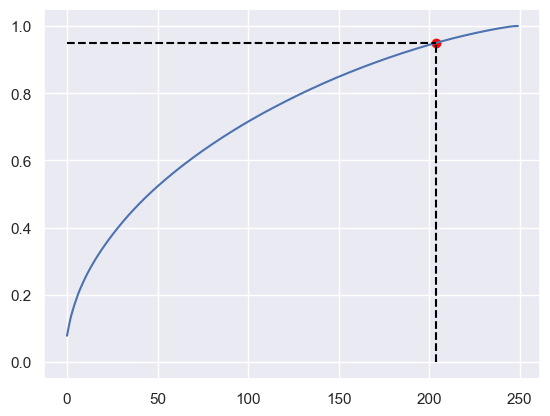

In [20]:
pca = PCA()
pca_array = pca.fit_transform(df_dim_red)
pca_array_df = pd.DataFrame(pca_array, columns=[f'PC{i+1}' for i in range(pca_array.shape[1])], index=df_dim_red.index)
merged_pca_array_df = pd.merge(pca_array_df, df_metaM['Condition'], left_index=True, right_index=True)
cumsum = np.cumsum(pca.explained_variance_ratio_)
plt.plot(cumsum)
nec_dimensions = np.argmax(cumsum >= 0.95)
plt.scatter(nec_dimensions, 0.95, color='red')
plt.plot([nec_dimensions, nec_dimensions], [0, 0.95], linestyle='--', color='black')
plt.plot([0, nec_dimensions], [0.95, 0.95], linestyle='--', color='black')
print(f"The number of dimensions needed to explain 95% of the variance is {nec_dimensions}")

Now the number of dimensions needed to explain 95% of the variance is 204, which is a bit higher than the previous dataset.

In [21]:
# we now use pca to visualize the data
three_dim_df = merged_pca_array_df[['PC1', 'PC2', 'PC3', 'Condition']]
three_dim_df.head()

PC1       PC2  \
output.STAR.2_B3_Norm_S57_Aligned.sortedByCoord... -11.733153 -8.942211   
output.STAR.2_B4_Norm_S58_Aligned.sortedByCoord... -17.064252  4.697082   
output.STAR.2_B5_Norm_S59_Aligned.sortedByCoord... -21.459996 -2.427312   
output.STAR.2_B6_Norm_S60_Aligned.sortedByCoord... -12.774610  2.729664   
output.STAR.2_B7_Hypo_S79_Aligned.sortedByCoord...   7.078282  9.258913   

                                                         PC3 Condition  
output.STAR.2_B3_Norm_S57_Aligned.sortedByCoord... -2.254930      Norm  
output.STAR.2_B4_Norm_S58_Aligned.sortedByCoord...  4.419943      Norm  
output.STAR.2_B5_Norm_S59_Aligned.sortedByCoord...  5.204875      Norm  
output.STAR.2_B6_Norm_S60_Aligned.sortedByCoord...  5.724528      Norm  
output.STAR.2_B7_Hypo_S79_Aligned.sortedByCoord... -2.543533      Hypo

In [22]:
import plotly.express as px

fig = px.scatter_3d(
    data_frame = three_dim_df,
    x = "PC1",
    y = "PC2",
    z = "PC3",
    title="3-dimensional representation of the data with UMAP",
    color = "Condition"
)
# Show the fig
fig.show()

In [23]:
import umap.umap_ as umap

n_neighbors_list = [2, 10, 50, df_dim_red.shape[0]-1]

umap_dict = {}
for n in n_neighbors_list:
    reducer = umap.UMAP(n_components=3, n_neighbors=n)
    embedding = reducer.fit_transform(df_dim_red)
    columns = [f'UMAP{i+1}' for i in range(embedding.shape[1])]
    umap_embedding_df = pd.DataFrame(embedding, columns=columns, index=df_dim_red.index)
    merged_umap = pd.merge(umap_embedding_df, df_metaM['Condition'], left_index=True, right_index=True)
    merged_umap['n_neighbors'] = [n]*df_dim_red.shape[0]
    umap_dict[n] = merged_umap
    
    fig = px.scatter_3d(
    data_frame = merged_umap,
    x = "UMAP1",
    y = "UMAP2",
    z = "UMAP3",
    title=f"3-dimensional representation of the data with UMAP, n_neighbors = {n}",
    color = "Condition"
    )
    fig.show()

As in ther other dataset, they look almost linearly separable.